In [5]:
import geopandas as gpd
import pandas as pd
import ee
import numpy as np
from scipy.stats import linregress, gaussian_kde
from src.data import mtbs
from src.data import raster
from src.data import pd_utils
from src.data import gedi_pipeline
from src.visualization.gedi_viz import geo_plot
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from src.data import k_nn

sns.set_theme()

import importlib
importlib.reload(raster)
importlib.reload(gedi_pipeline)
importlib.reload(k_nn)

2023-05-14 11:40:05,766 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.k_nn' from '/home/jk871/fire-regen/src/data/k_nn.py'>

In [6]:
gedi_gpd = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
print(f'Total number of GEDI shots available for the region: {gedi_gpd.shape[0]}')

Total number of GEDI shots available for the region: 9884257


In [7]:
gedi_gpd = gedi_pipeline.process_shots(gedi_gpd)

### Filter GEDI data

In [8]:
gedi_burned, gedi_unburned = gedi_pipeline.filter_shots(gedi_gpd)

2023-05-14 11:42:03,595 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:36]
2023-05-14 11:42:03,912 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:41]
2023-05-14 11:42:05,256 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:47]


In [9]:
gedi_burned = gedi_pipeline.filter_shots_for_regrowth_analysis(gedi_burned)

2023-05-14 11:42:14,157 DEBUG: Number of shots that happened after fires:                    1248004 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:64]
2023-05-14 11:42:14,355 DEBUG: Number of shots that burned exactly once:                    1085566 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:69]
2023-05-14 11:42:14,633 DEBUG: Number of shots that burned in 2-4 categories:                    917889 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:74]
2023-05-14 11:42:14,756 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 3x3 pixels have the same severity):                    651178 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:78]


### Presence of plant classes in each GEDI category

Land cover is being currently derived from Dynamic World estimate from 2019. Legend:
* 0 - water
* 1 - trees
* 2 - grass
* 3 - flooded_vegetation
* 4 - crops
* 5 - shrub_and_scrub
* 6 - built
* 7 - bare
* 8 - snow and ice

TODO: Actually obtain land cover from the time before fire for burned pixels.

<AxesSubplot: xlabel='land_cover_median', ylabel='Count'>

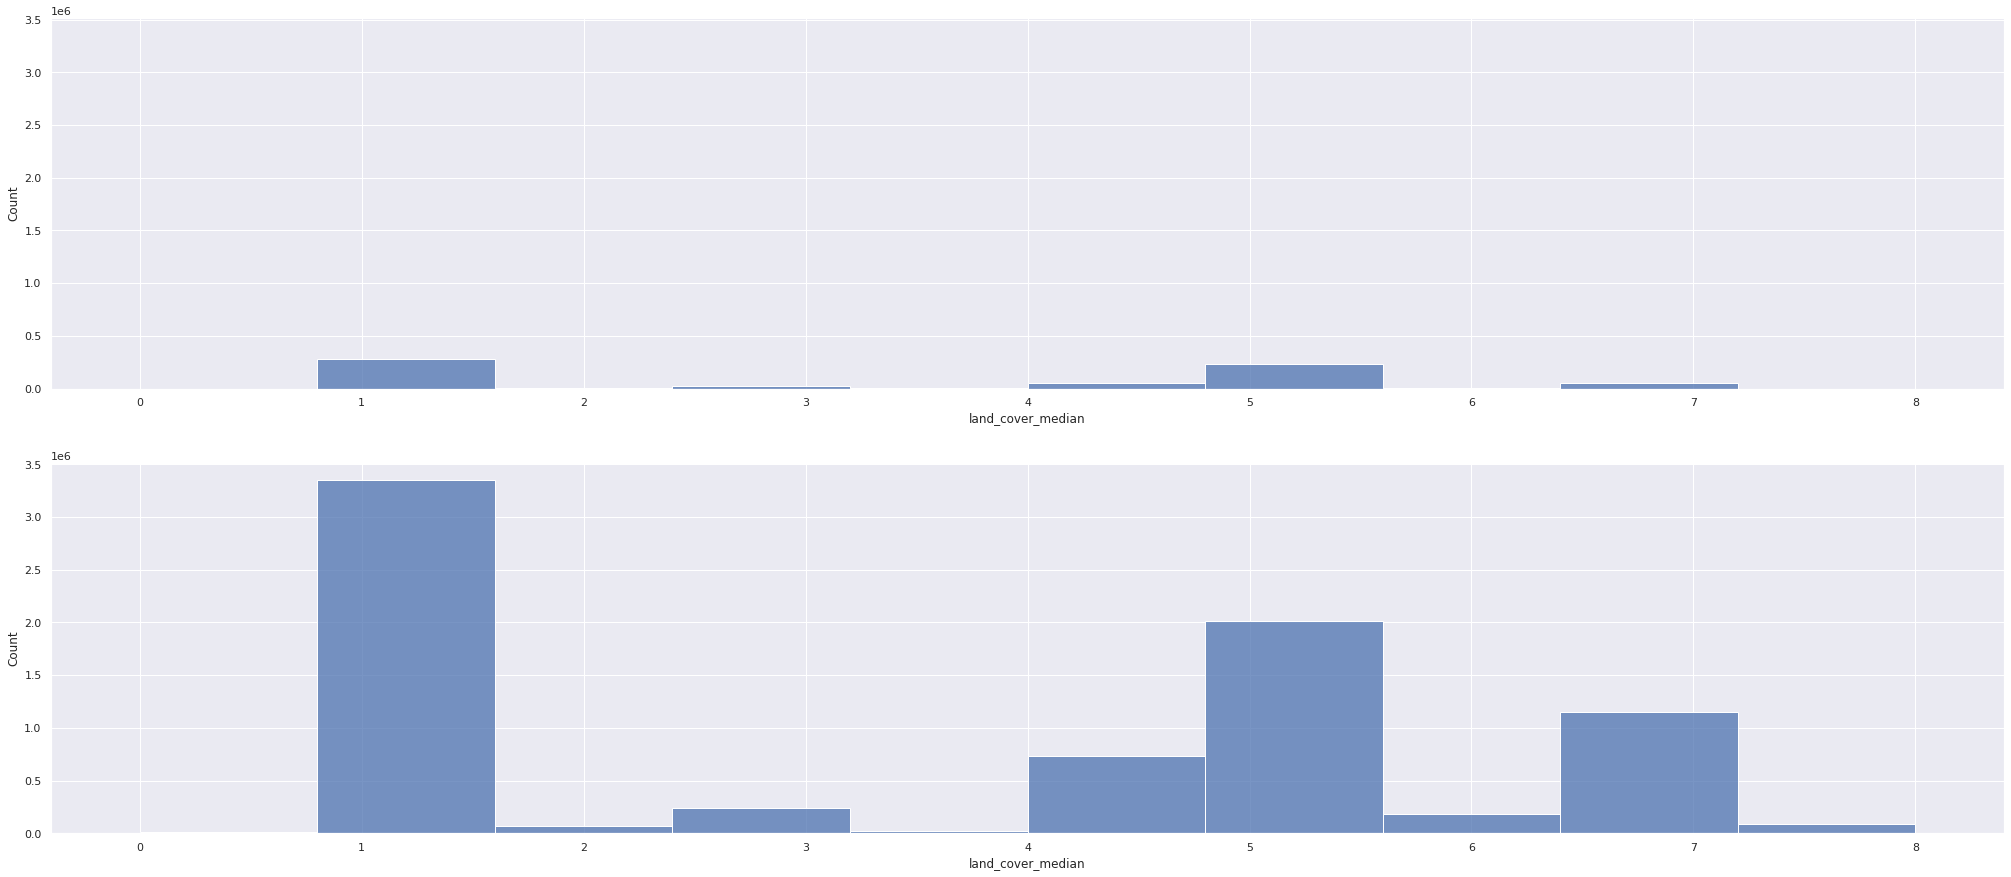

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(35, 15), sharey=True)
sns.histplot(gedi_burned, x='land_cover_median', ax=ax[0], bins=10)
sns.histplot(gedi_unburned, x='land_cover_median', ax=ax[1], bins=10)

### Analyze only trees - land cover == 1

In [10]:
gedi_burned_trees = gedi_pipeline.filter_for_trees(gedi_burned)
gedi_unburned_trees = gedi_pipeline.filter_for_trees(gedi_unburned)
print(f'GEDI shots that burned trees: {gedi_burned_trees.shape[0]}')
print(f'GEDI tree shots that didn\'t burn: {gedi_unburned_trees.shape[0]}')

GEDI shots that burned trees: 260640
GEDI tree shots that didn't burn: 3152125


In [11]:
gedi_trees = pd.concat([gedi_burned_trees, gedi_unburned_trees])

In [85]:
# Get rid of the first two years as the number of samples is skewing the data.
gedi_trees = gedi_trees[(gedi_trees.time_since_burn != 1) & ((gedi_trees.time_since_burn != 2))]

In [86]:
gedi_trees = gedi_pipeline.add_time_since_burn_categories(gedi_trees)

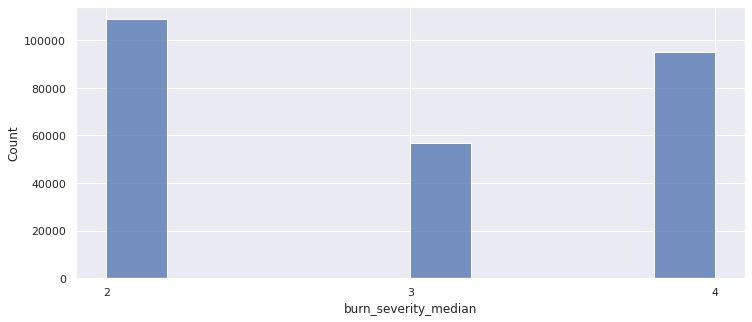

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
g = sns.histplot(gedi_burned_trees, x='burn_severity_median', bins=10)
g.set_xticks(range(2, 5))

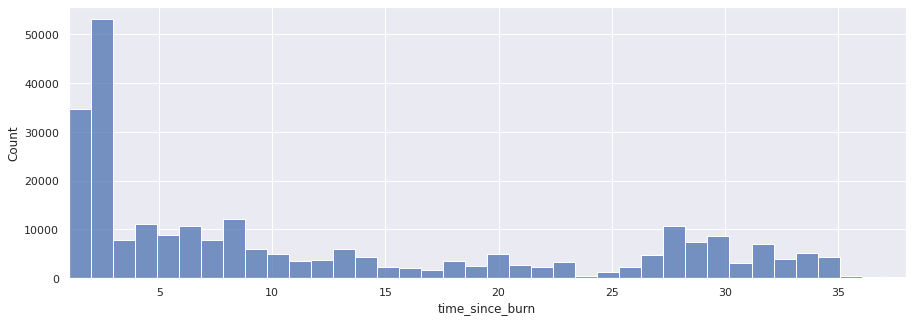

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.histplot(gedi_burned_trees, x='time_since_burn', bins=38)
ax.margins(x=0)

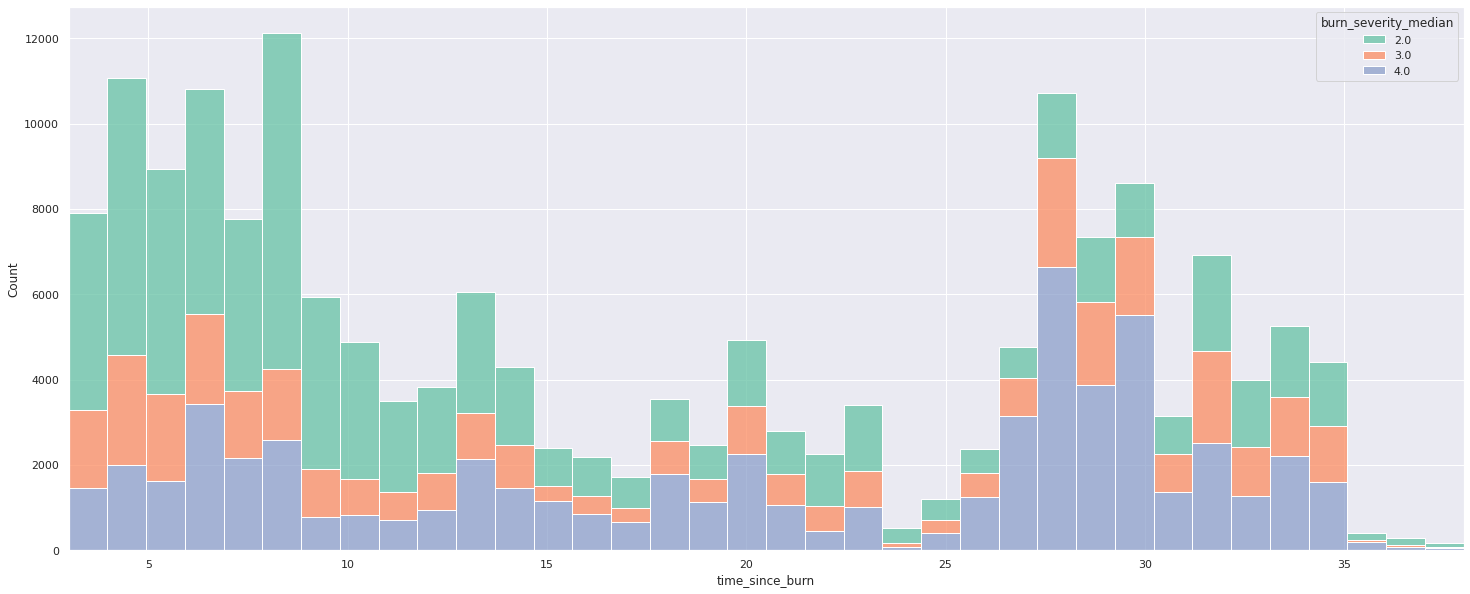

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn', hue='burn_severity_median', palette='Set2', multiple="stack", bins=36)
ax.margins(x=0)

### Boxplot comparisons

(0.0, 1000.0)

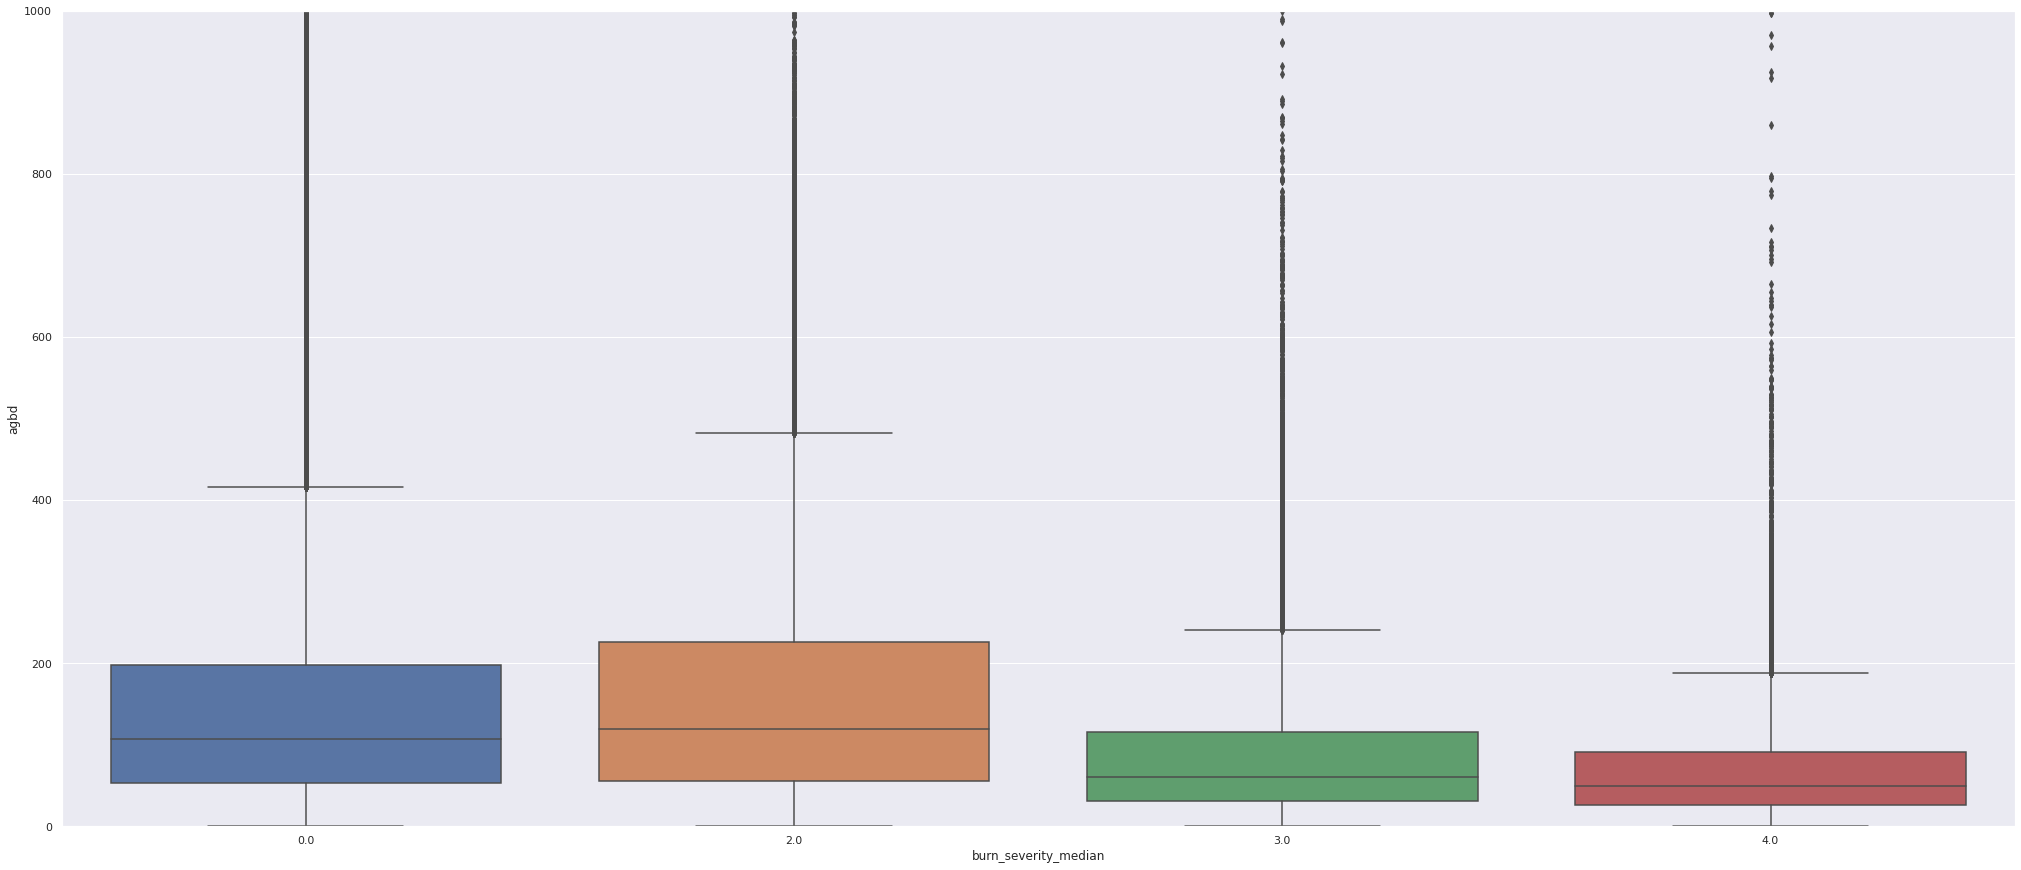

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees, x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

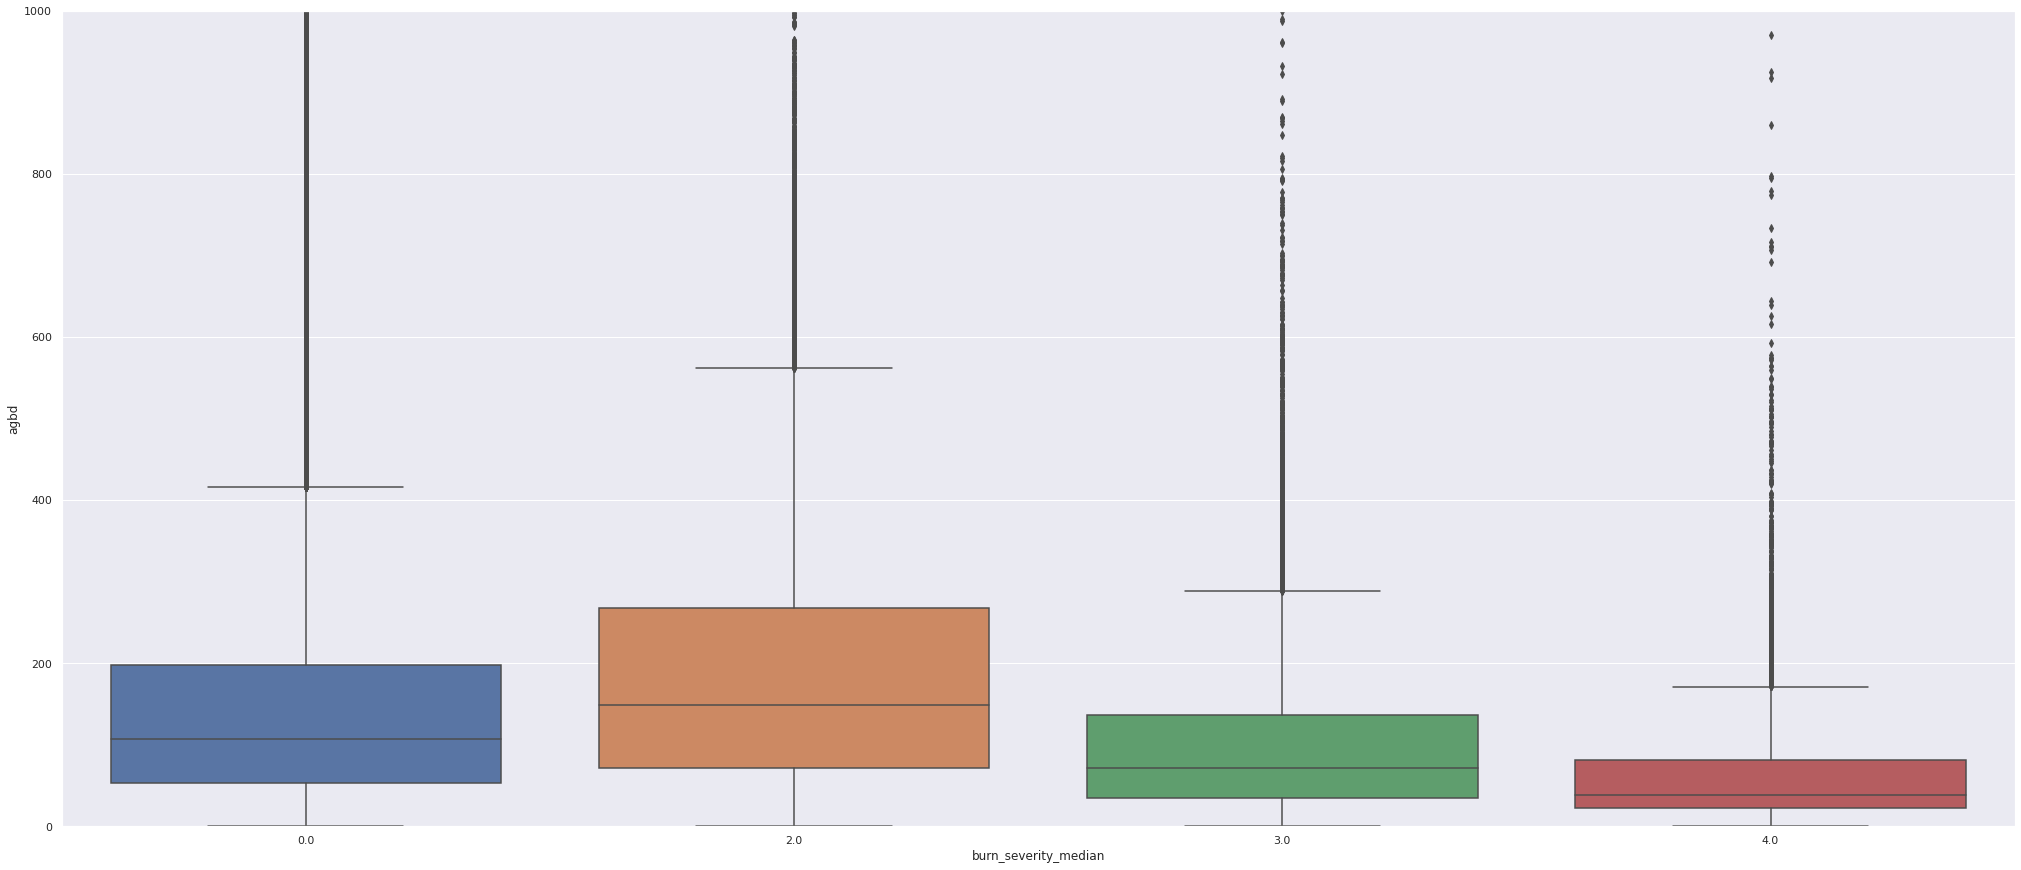

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_10'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

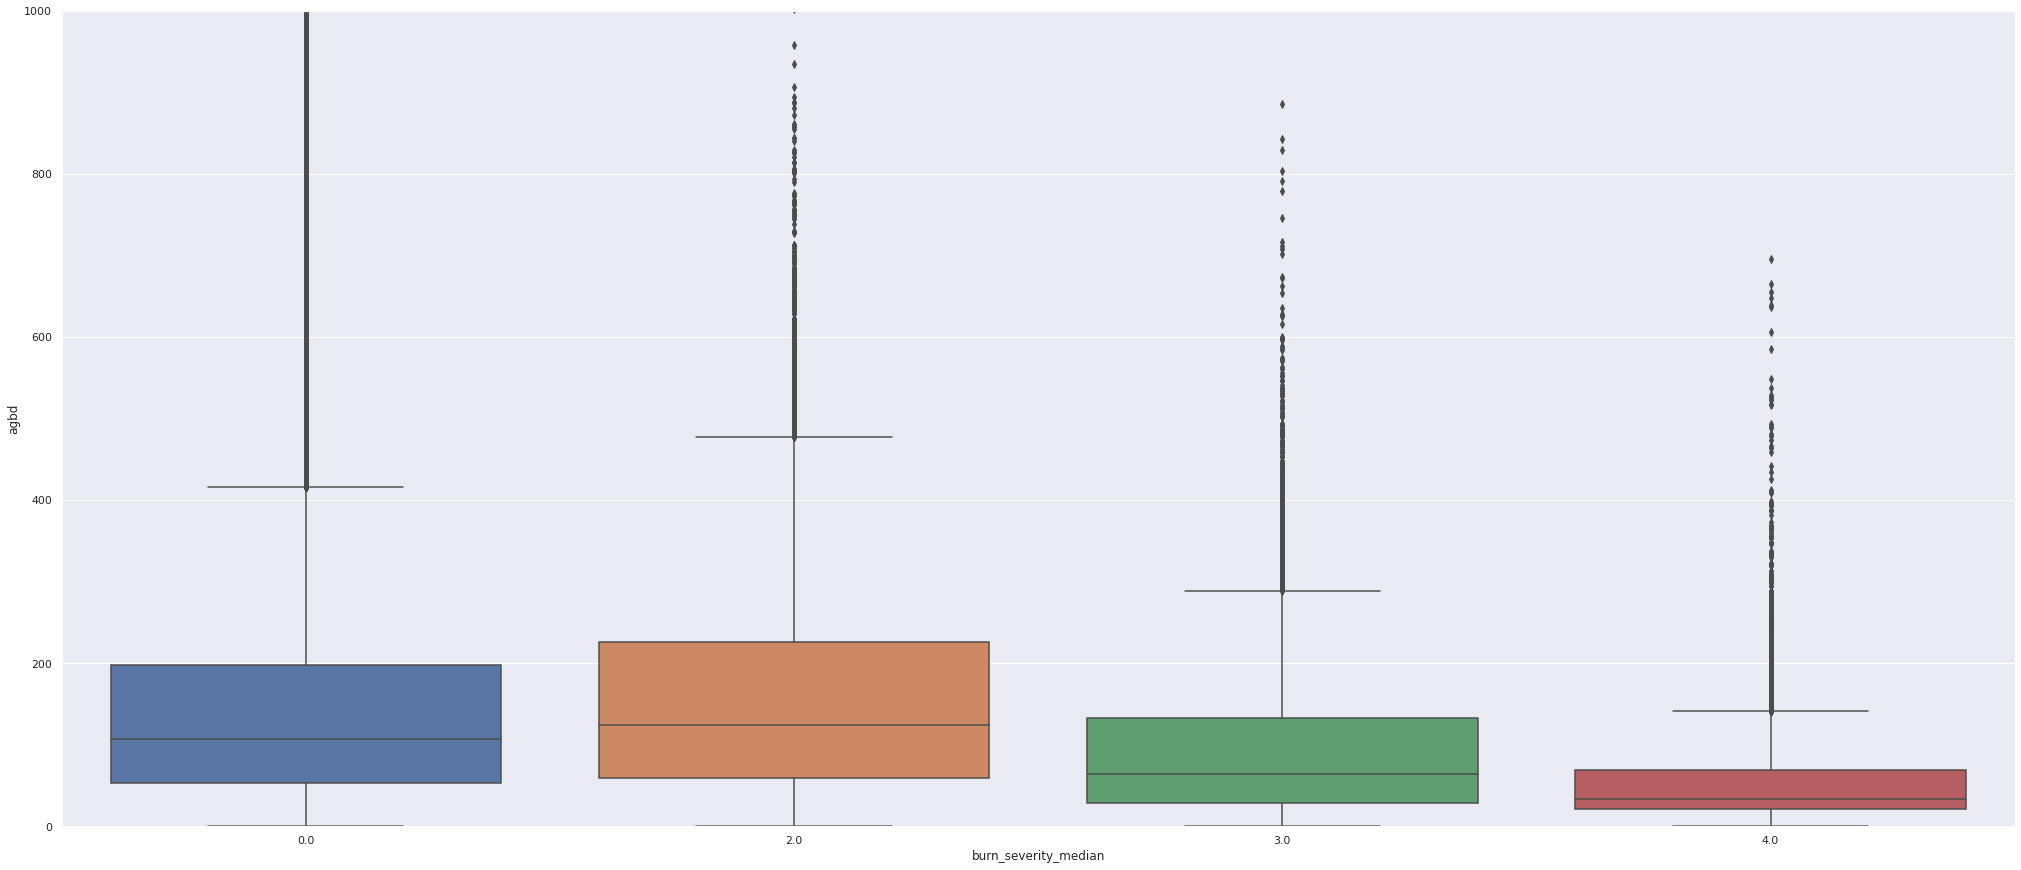

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_20'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

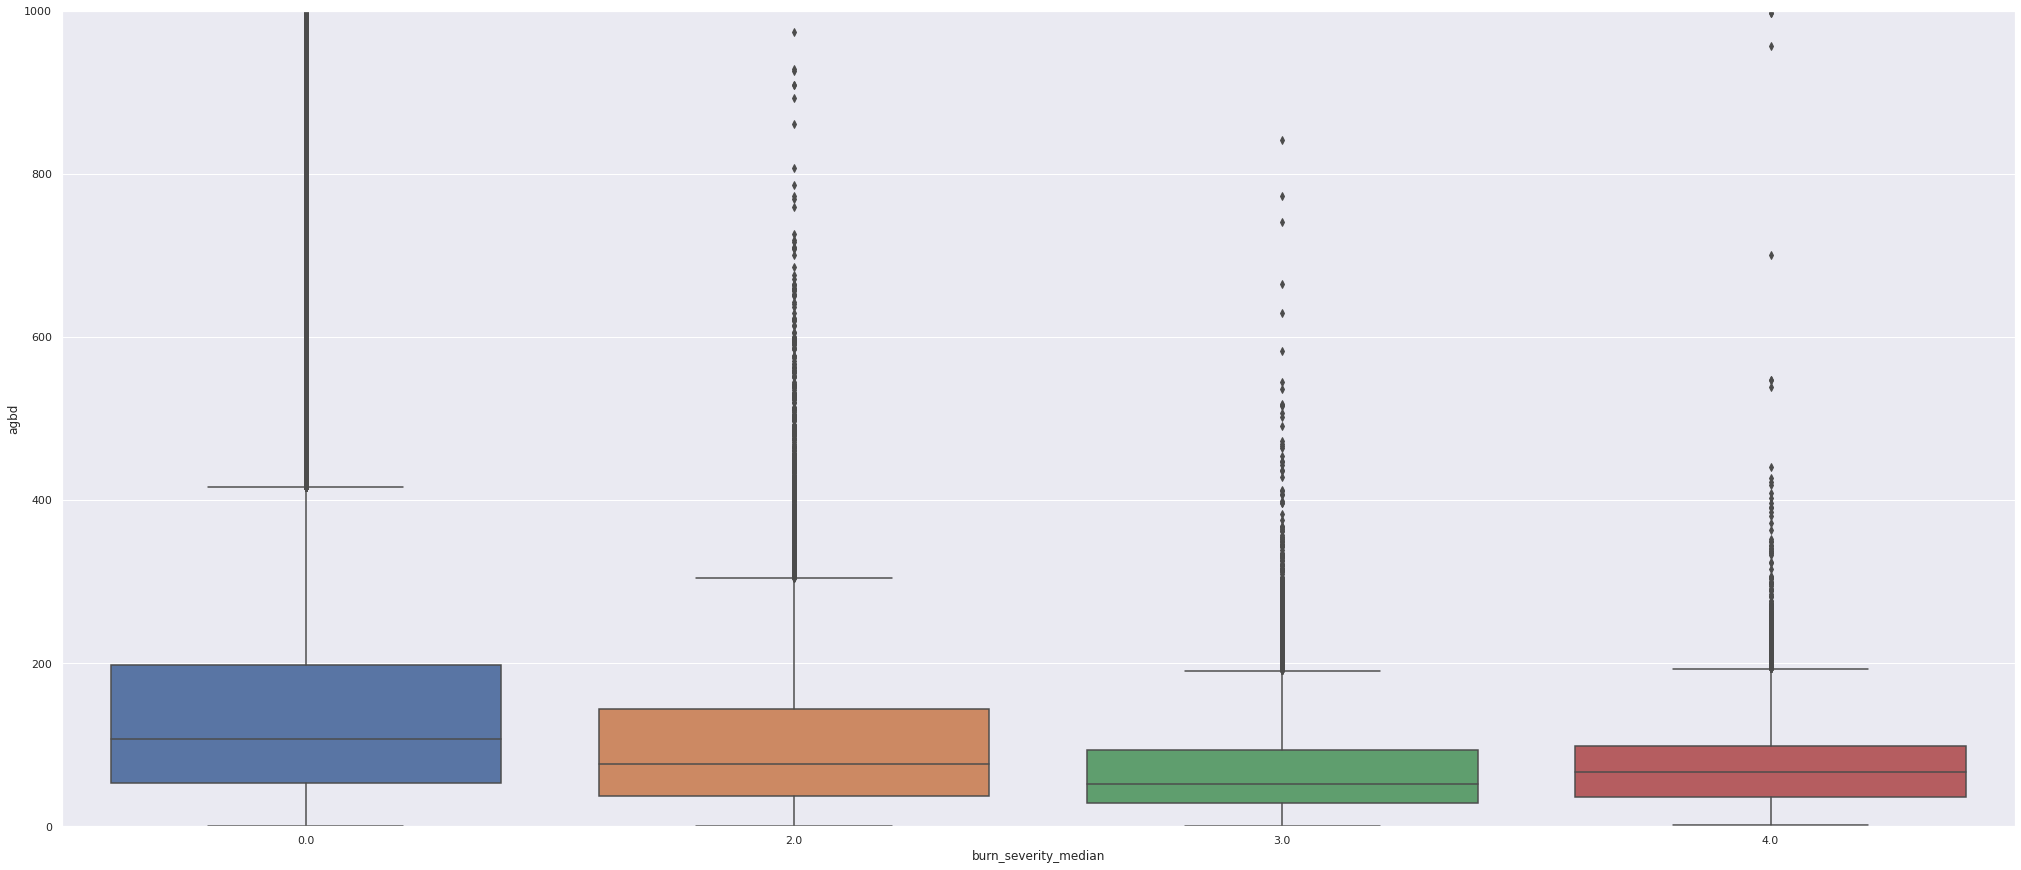

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_30'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

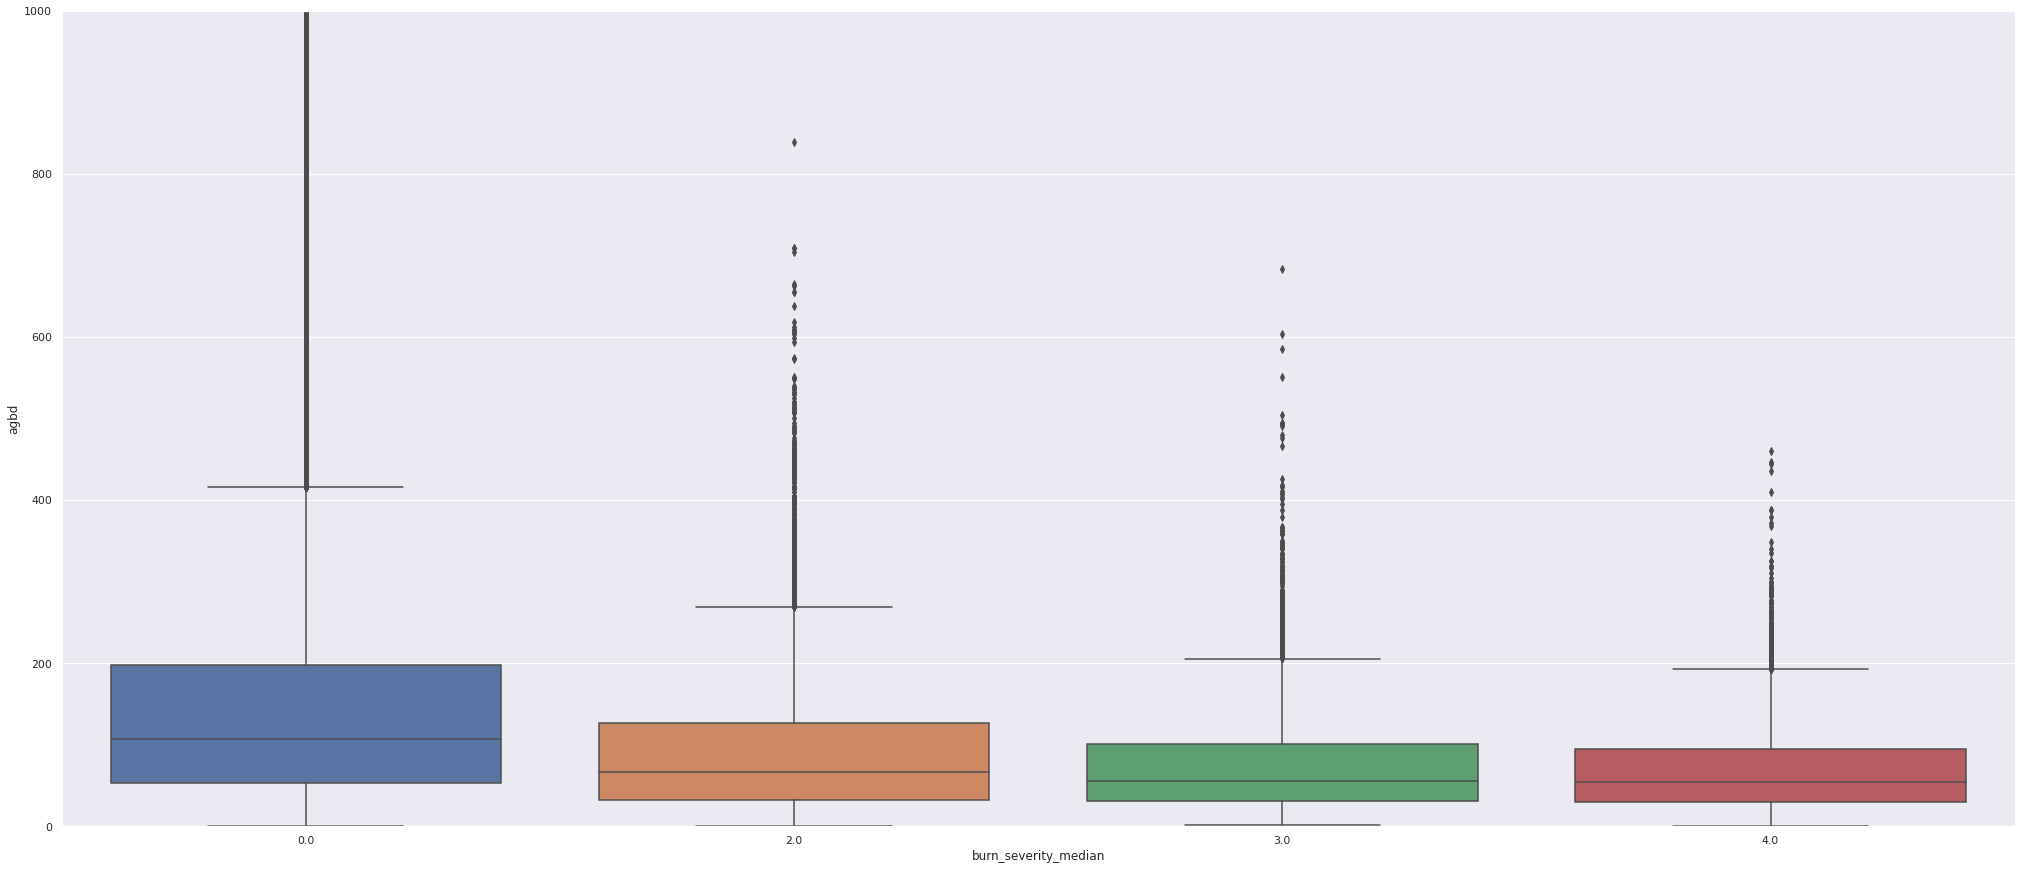

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_40'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

# AGBD timeplots

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

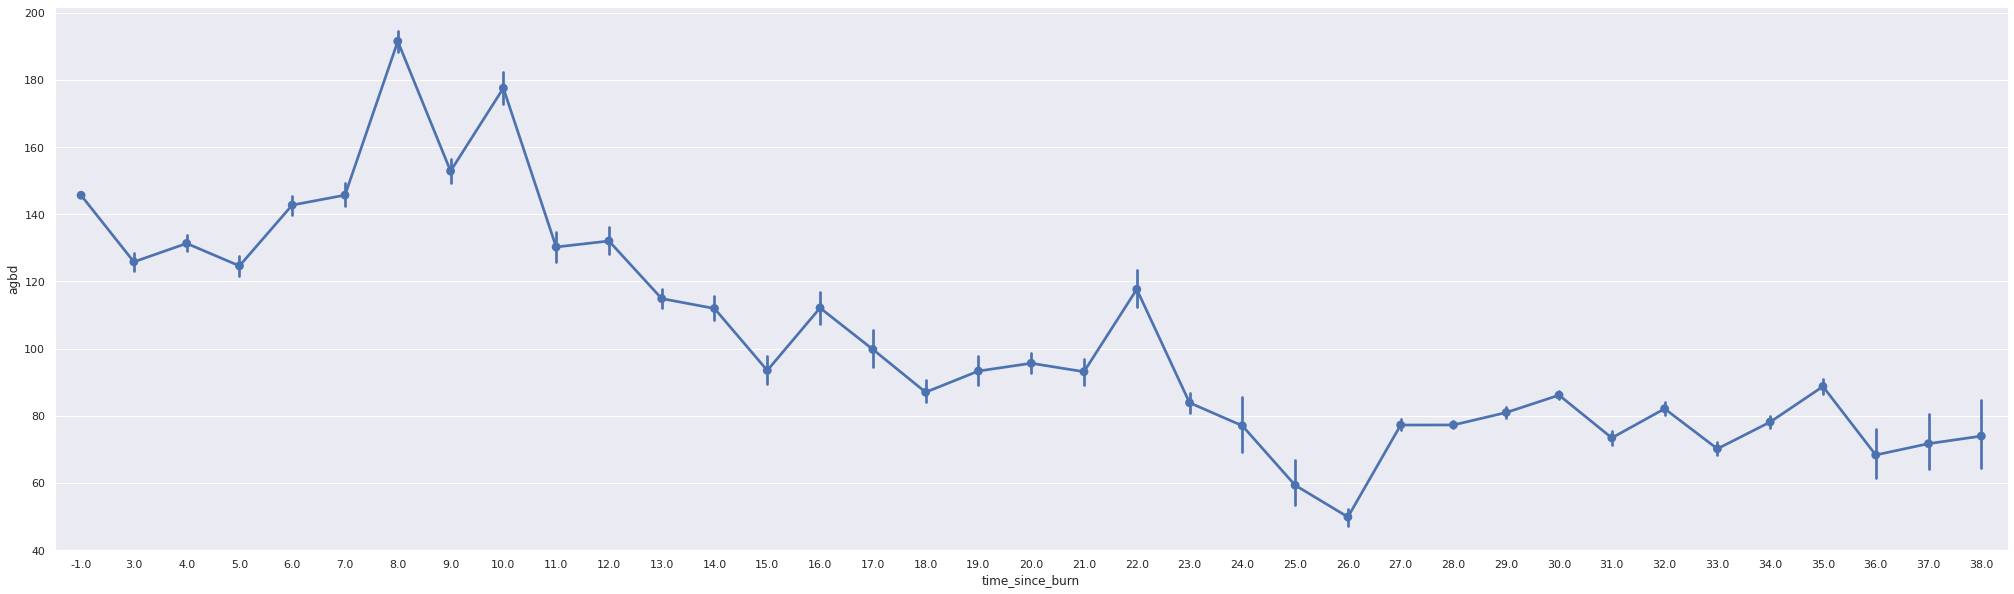

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_trees, x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

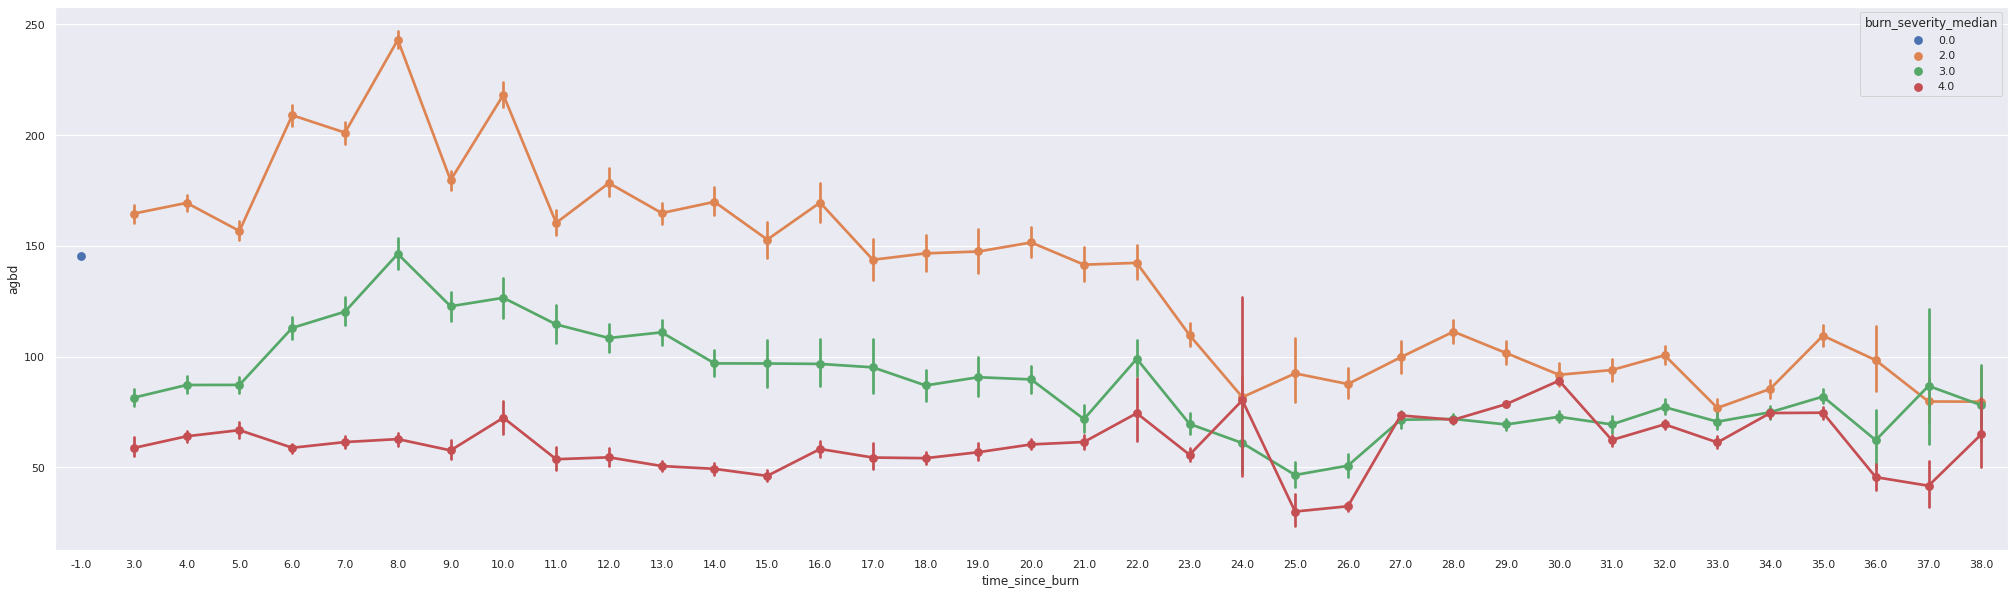

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_trees, x='time_since_burn', y='agbd', hue='burn_severity_median')

Text(0, 0.5, 'GEDI AGBD')

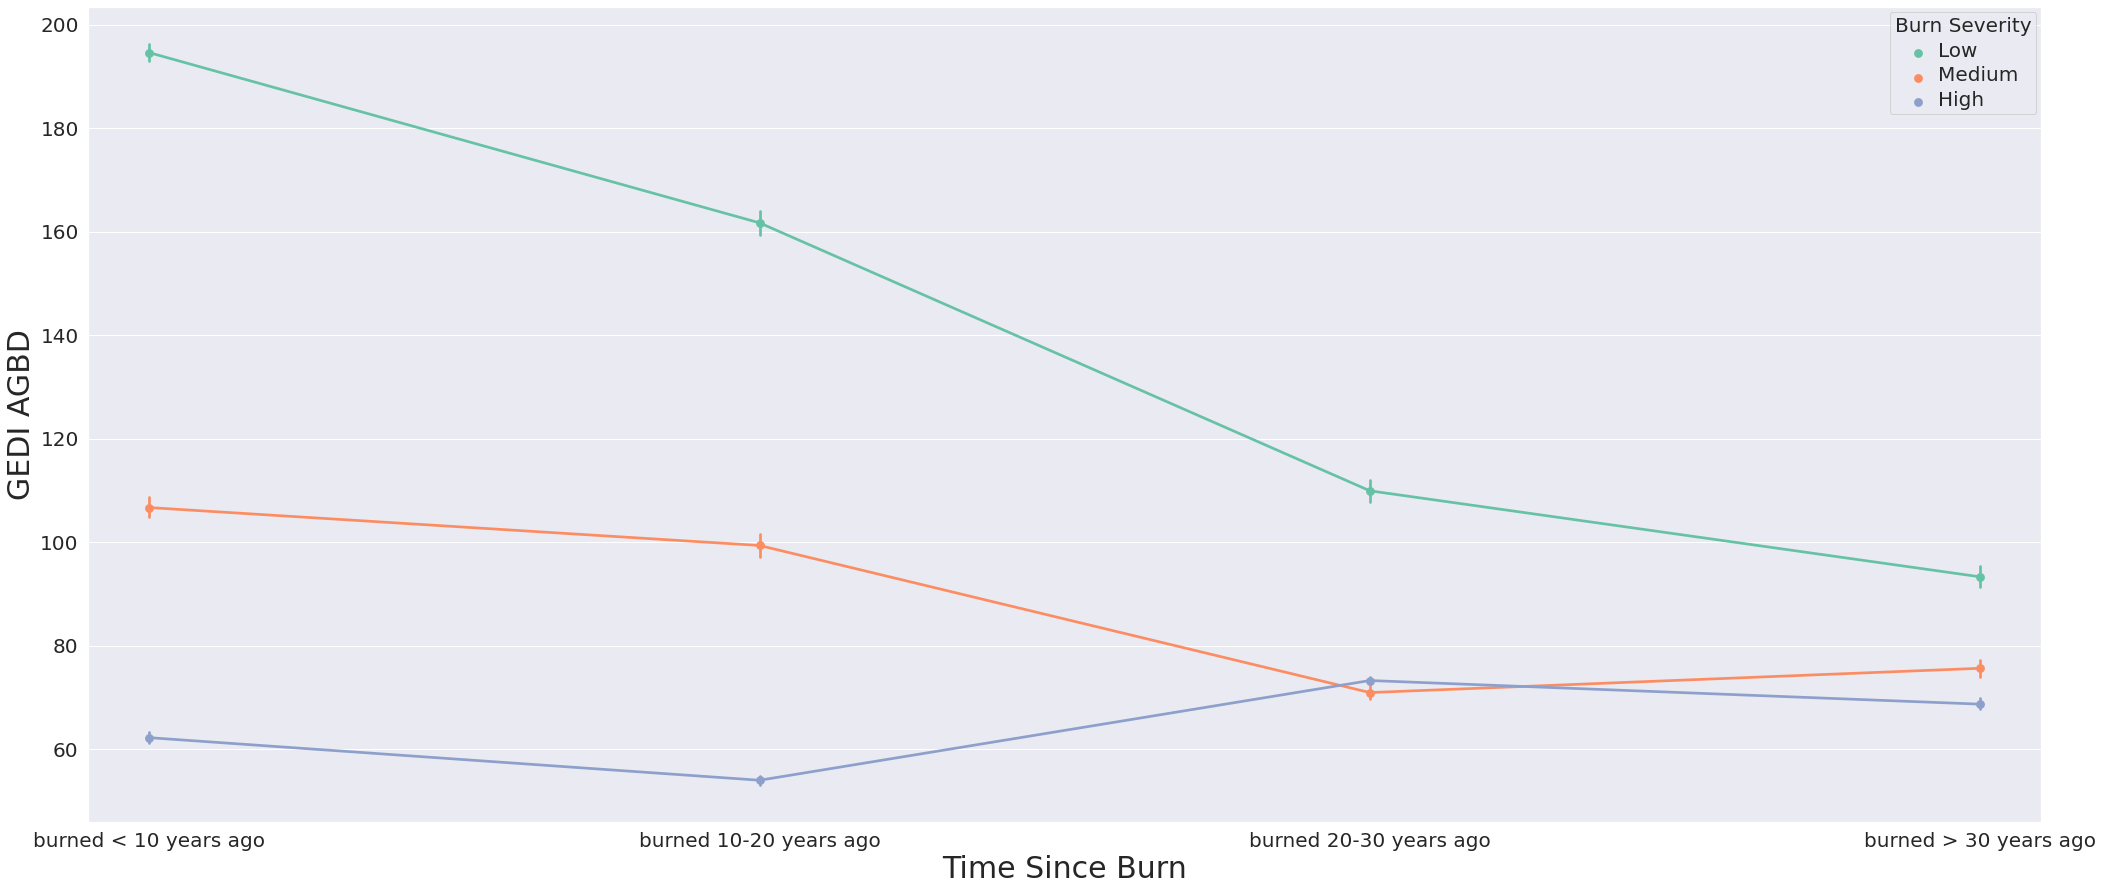

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.pointplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

Text(0, 0.5, 'GEDI AGBD')

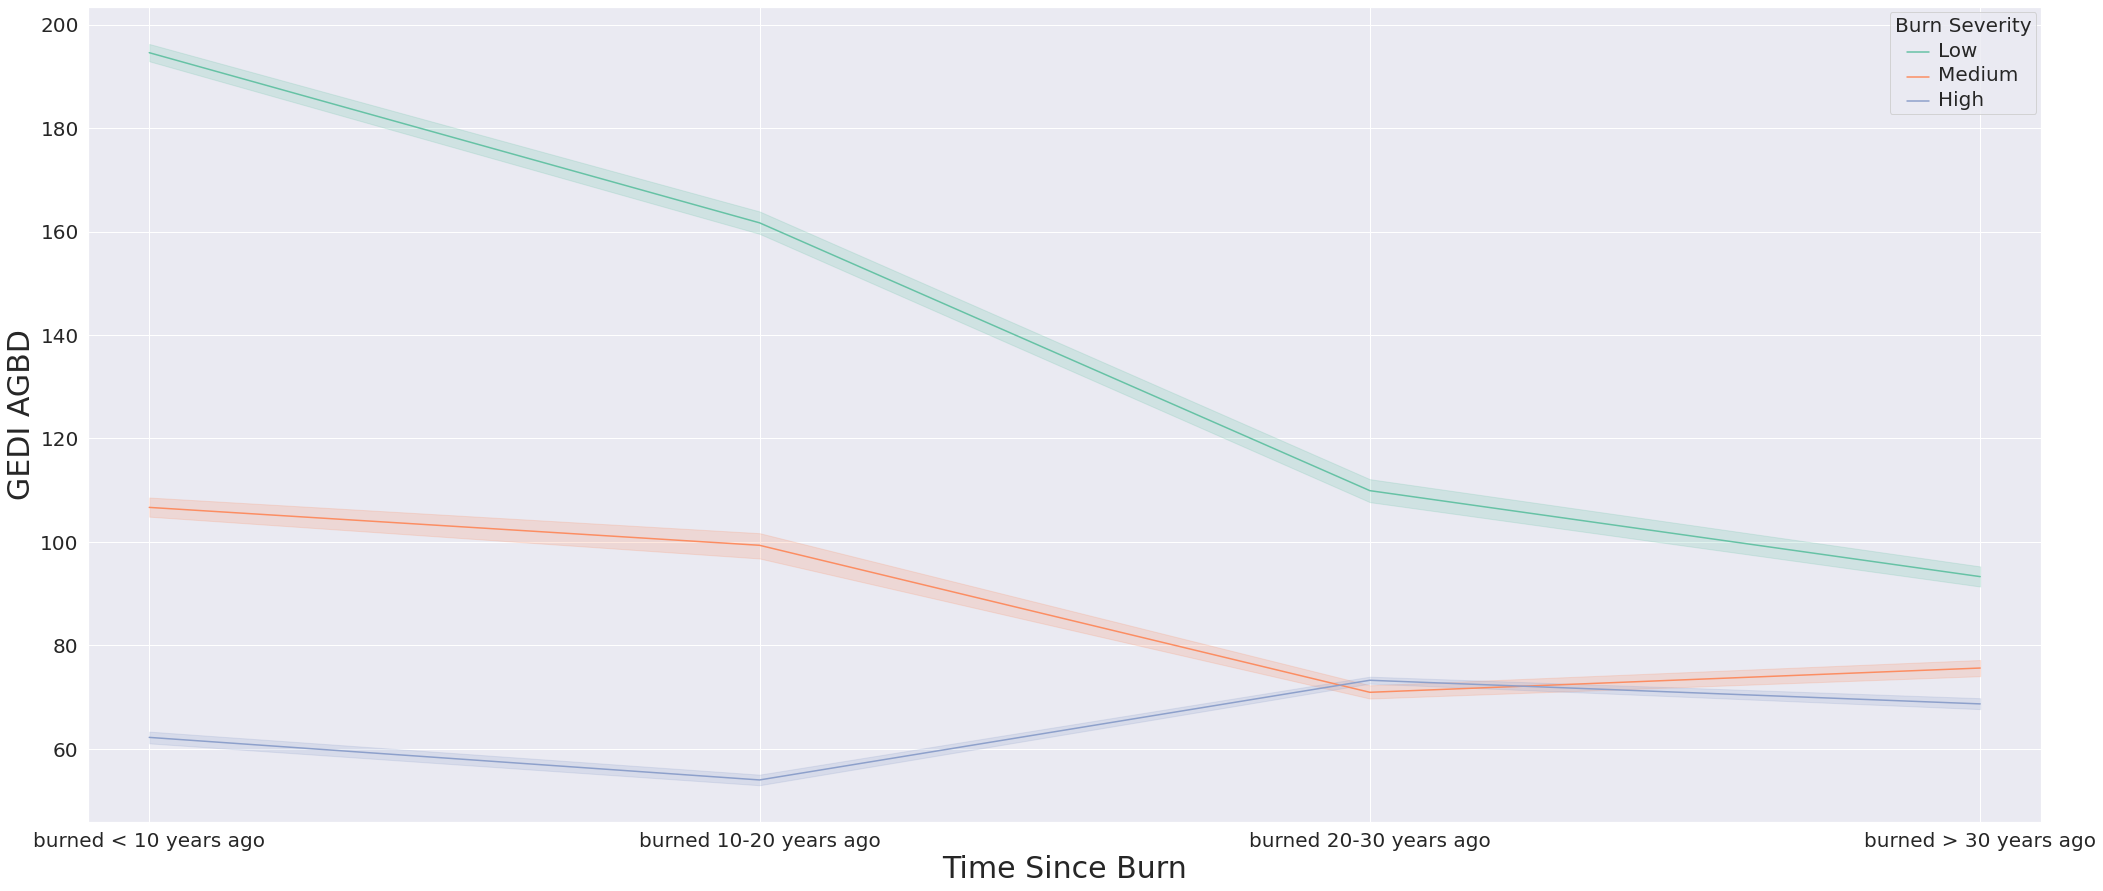

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.lineplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

Text(0, 0.5, 'GEDI AGBD')

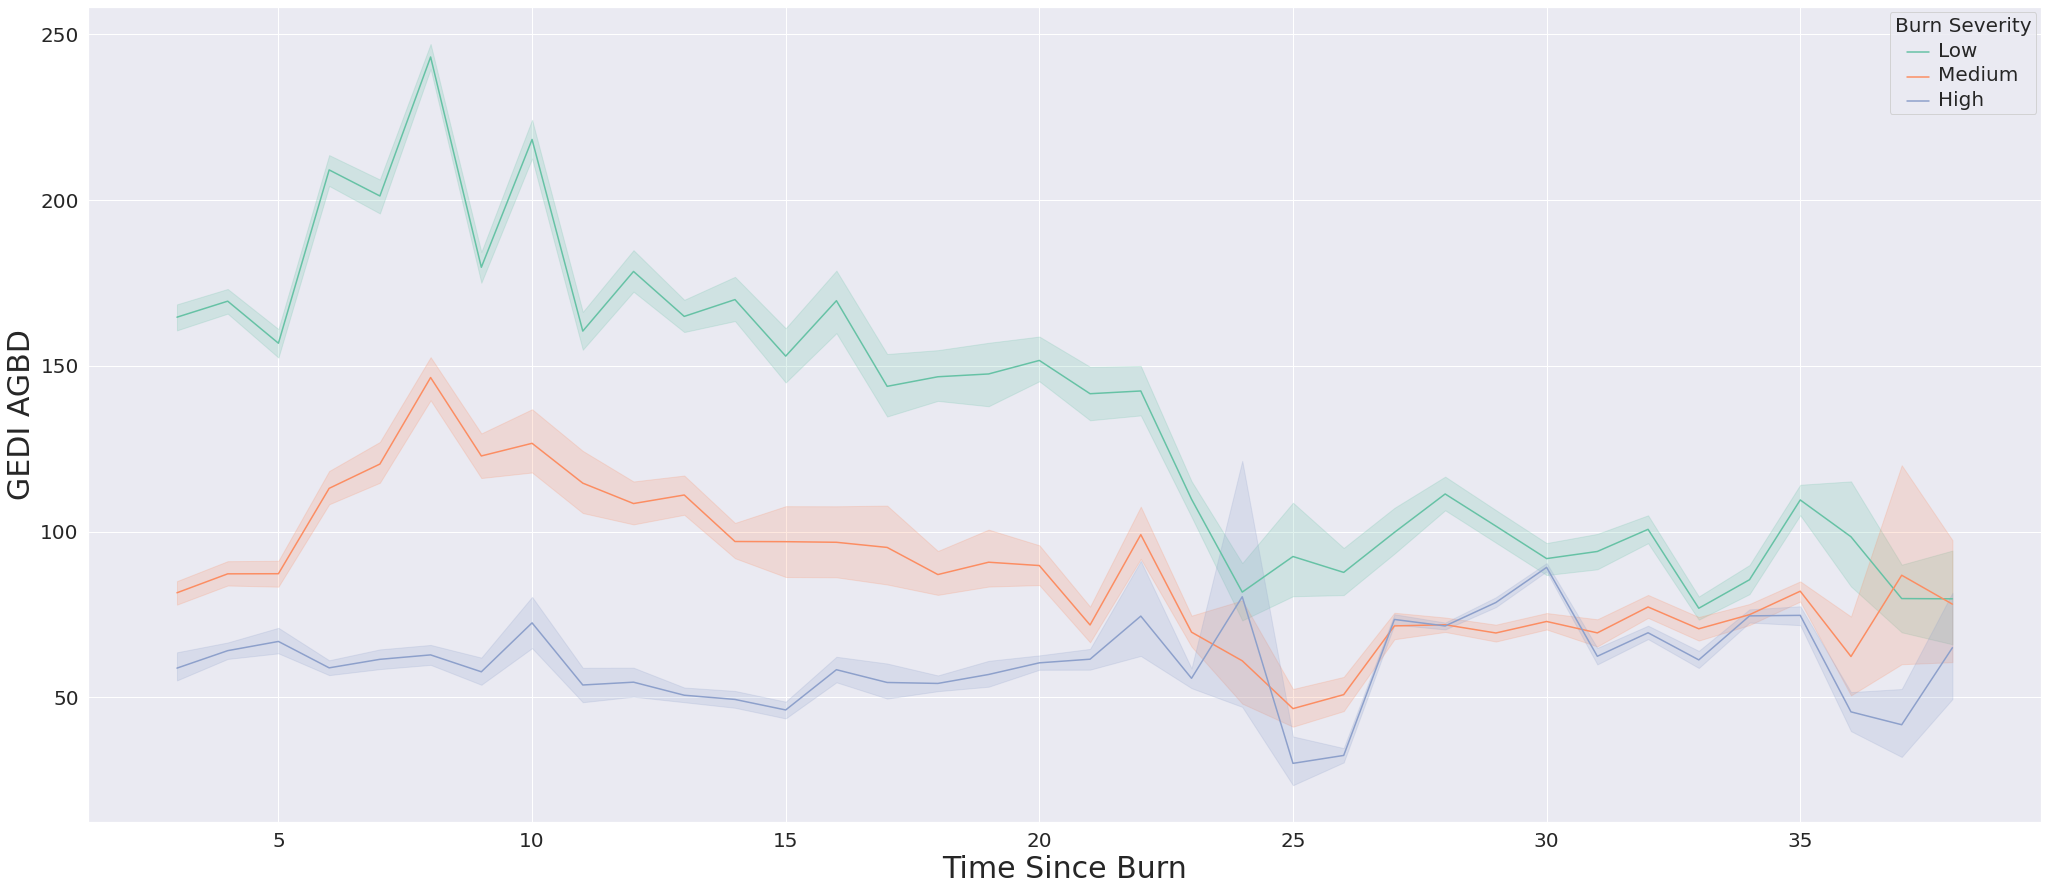

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.lineplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

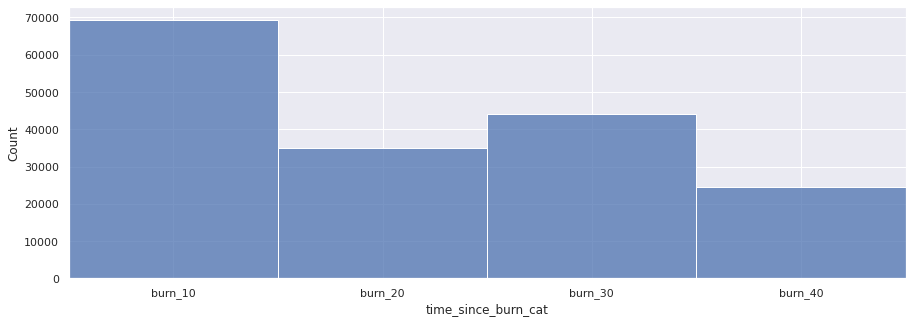

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat')
ax.margins(x=0)

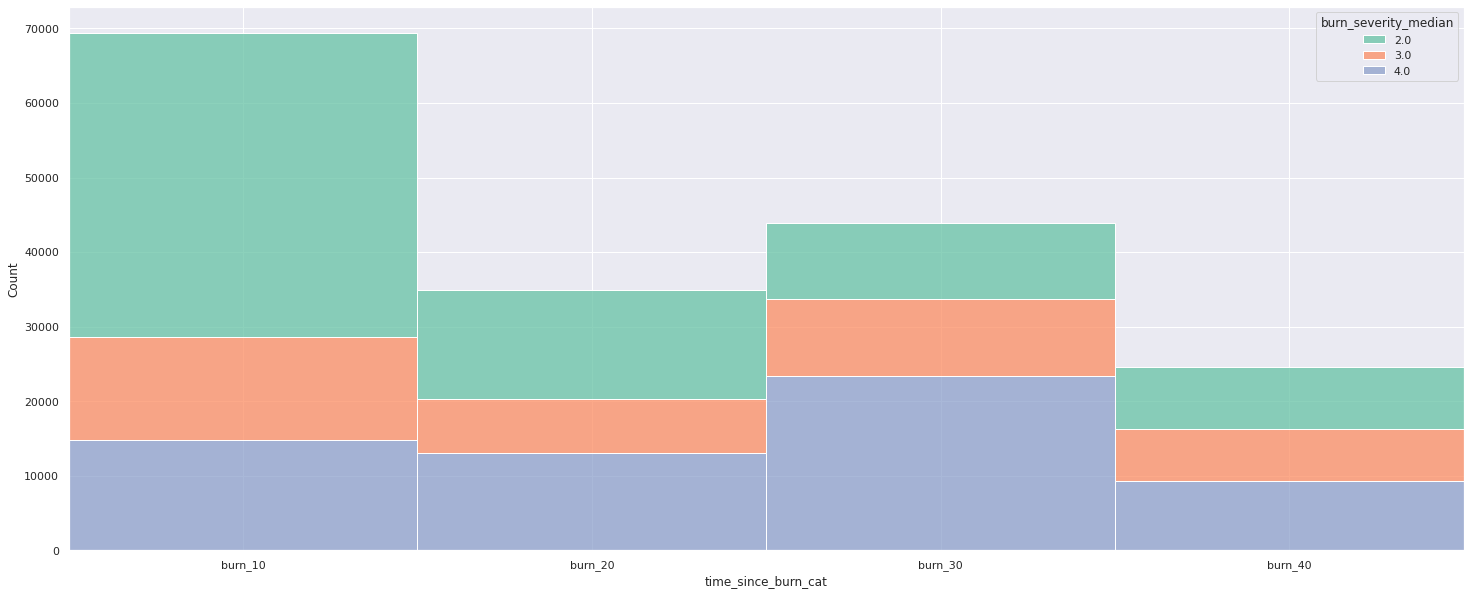

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', hue='burn_severity_median', palette='Set2', multiple="stack")
ax.margins(x=0)

In [116]:
gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2].shape[0]

108723

Hypothesis to explain above: pixels that burned with low and medium severity > 30 years ago are more likely to reburn, than the ones that burned with high severity due to fuel reduction.

What percentage of each severity category reburns? Fire return interval must depend on the severity of the previous burn?

In [12]:
def plot_pdf(df: pd.DataFrame, x_col: str, y_col:str, x_label: str, y_label: str, y_lim: tuple):
    n = len(df)
    print(n)

    x = df[x_col].values
    y = df[y_col].values

    # Calculate the point density distribution per age group
    x_values = np.unique(x)
    z = np.zeros(y.shape)
    for i in x_values:
        z[x == i] = gaussian_kde(y[x == i])(y[x == i])


    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # limit to only the points with high enough density
    # x = x[z > 0.005]
    # y = y[z > 0.005]
    # z = z[z > 0.005]

    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    im = ax.scatter(x, y, c=z, s=500, cmap='PuRd')
    ax.set_ylim(y_lim)
    ax.set_xticks(x_values[::2])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(x_label, size=15)
    ax.set_ylabel(y_label, size=15)
    plt.colorbar(im)

    plt.show()

108723


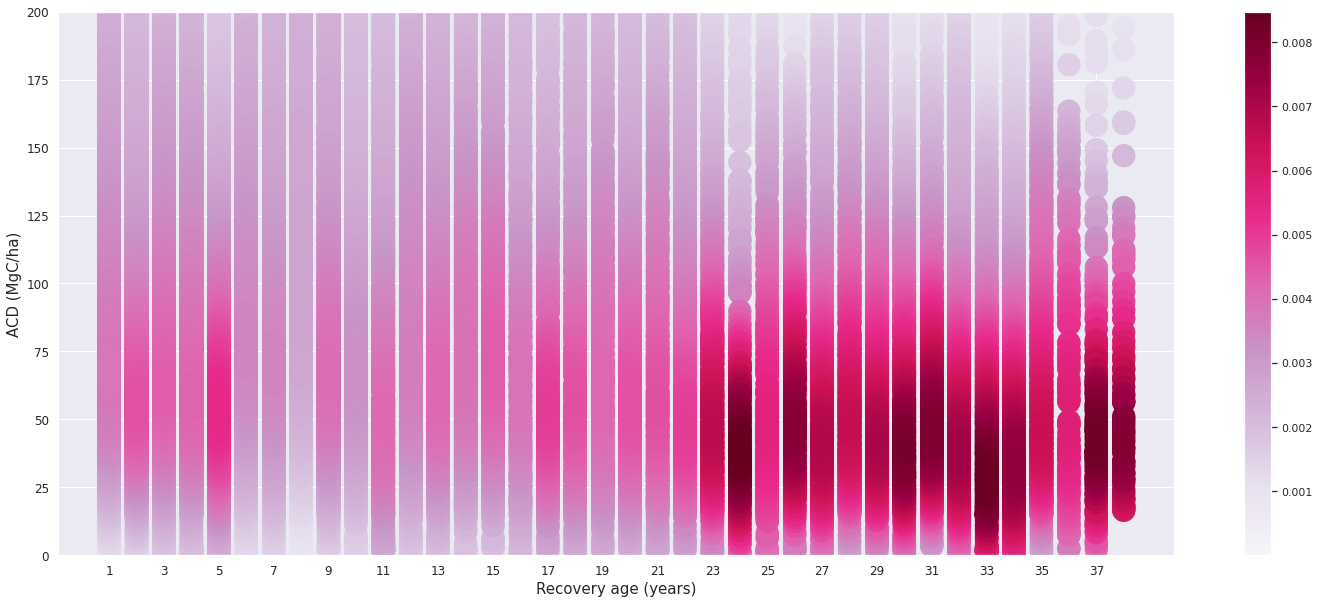

In [118]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2],
         'time_since_burn',
         'agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 200))

57017


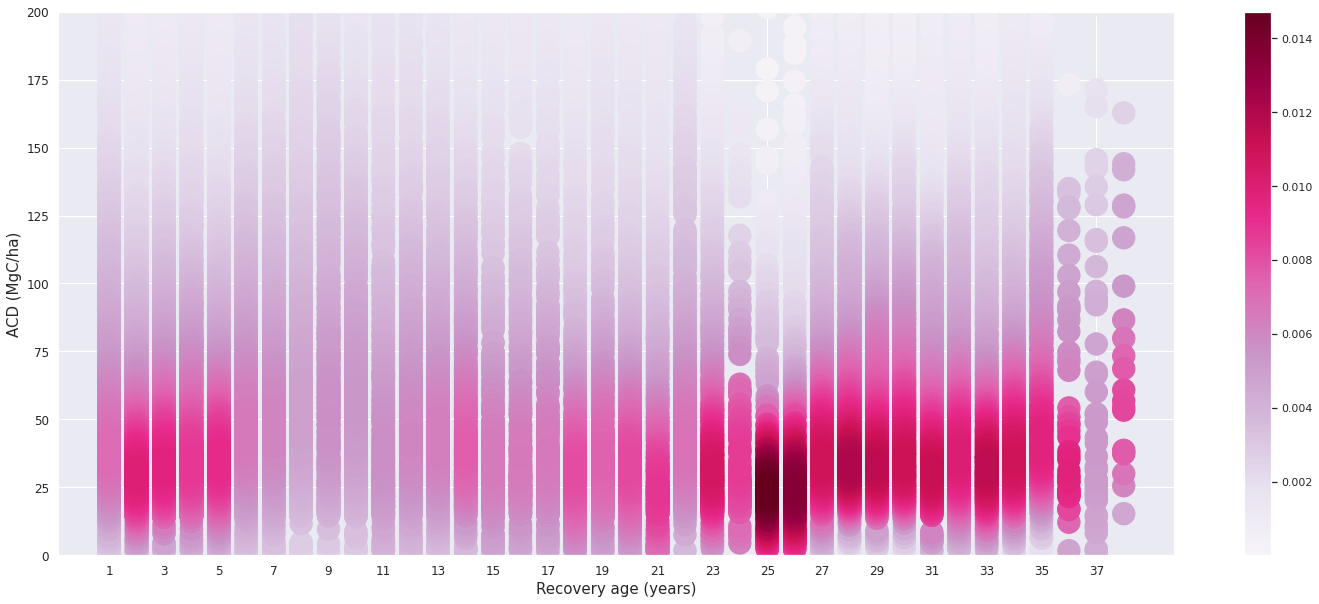

In [119]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3],
         'time_since_burn',
         'agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 200))

94900


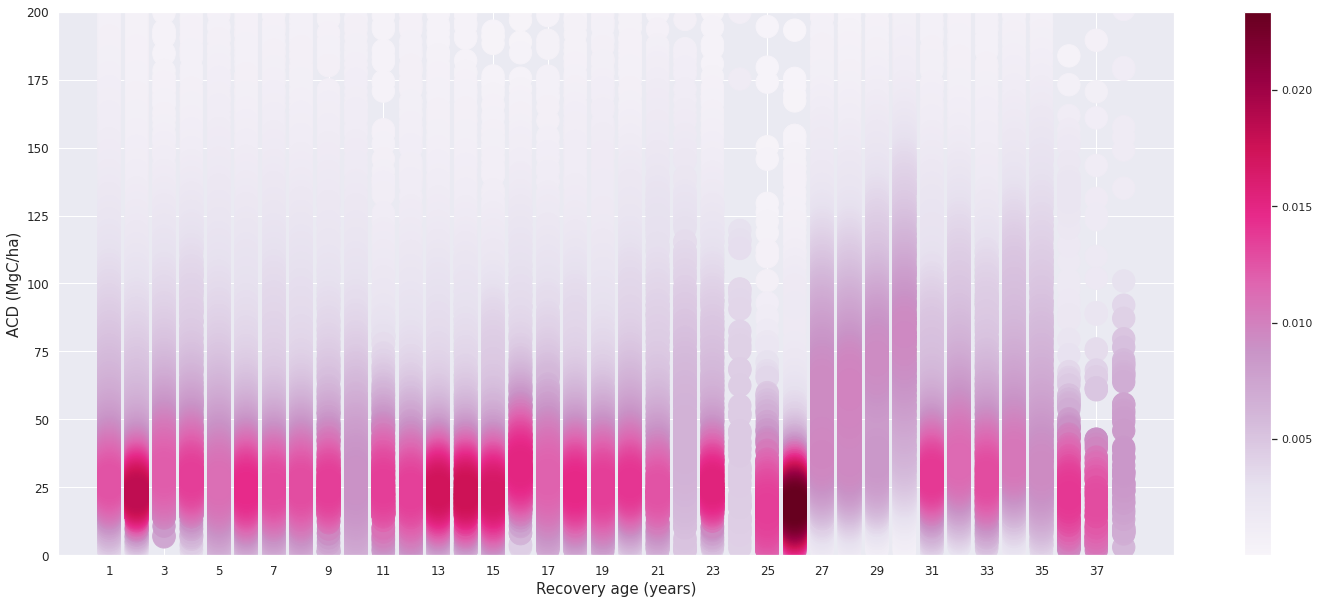

In [120]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4],
         'time_since_burn',
         'agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 200))

### Find nearest neighbours

In [13]:
nn_indeces, nn_distances, nn_avg_agbd = k_nn.nearest_neighbors(gedi_burned_trees, gedi_unburned_trees, 'agbd', 200)

In [14]:
gedi_burned_trees['rel_agbd'] = gedi_burned_trees.agbd / nn_avg_agbd

In [15]:
gedi_burned_trees.to_csv('/maps/fire-regen/data/burned_trees_rel_agbd_200_nn.csv')

In [13]:
nn_avg_agbd

array([67.29158959, 67.29158959, 67.29158959, 67.29158959, 67.29158959,
       67.29158959, 67.29158959, 67.29158959, 60.96015707, 60.96015707])

<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd'>

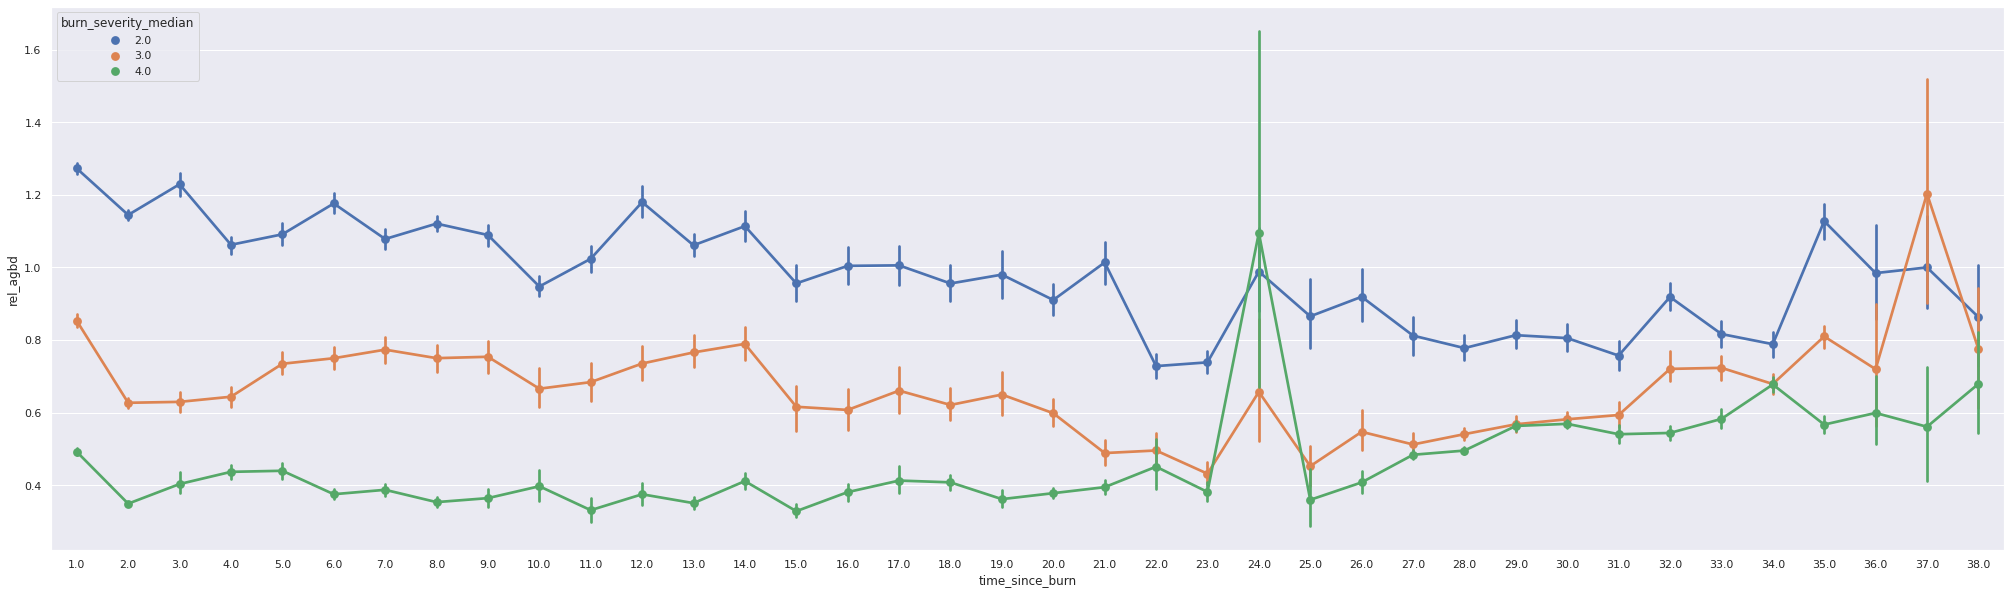

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_trees, x='time_since_burn', y='rel_agbd', hue='burn_severity_median')

In [22]:
gedi_burned_trees = gedi_pipeline.add_time_since_burn_categories(gedi_burned_trees)

Text(0, 0.5, 'GEDI AGBD')

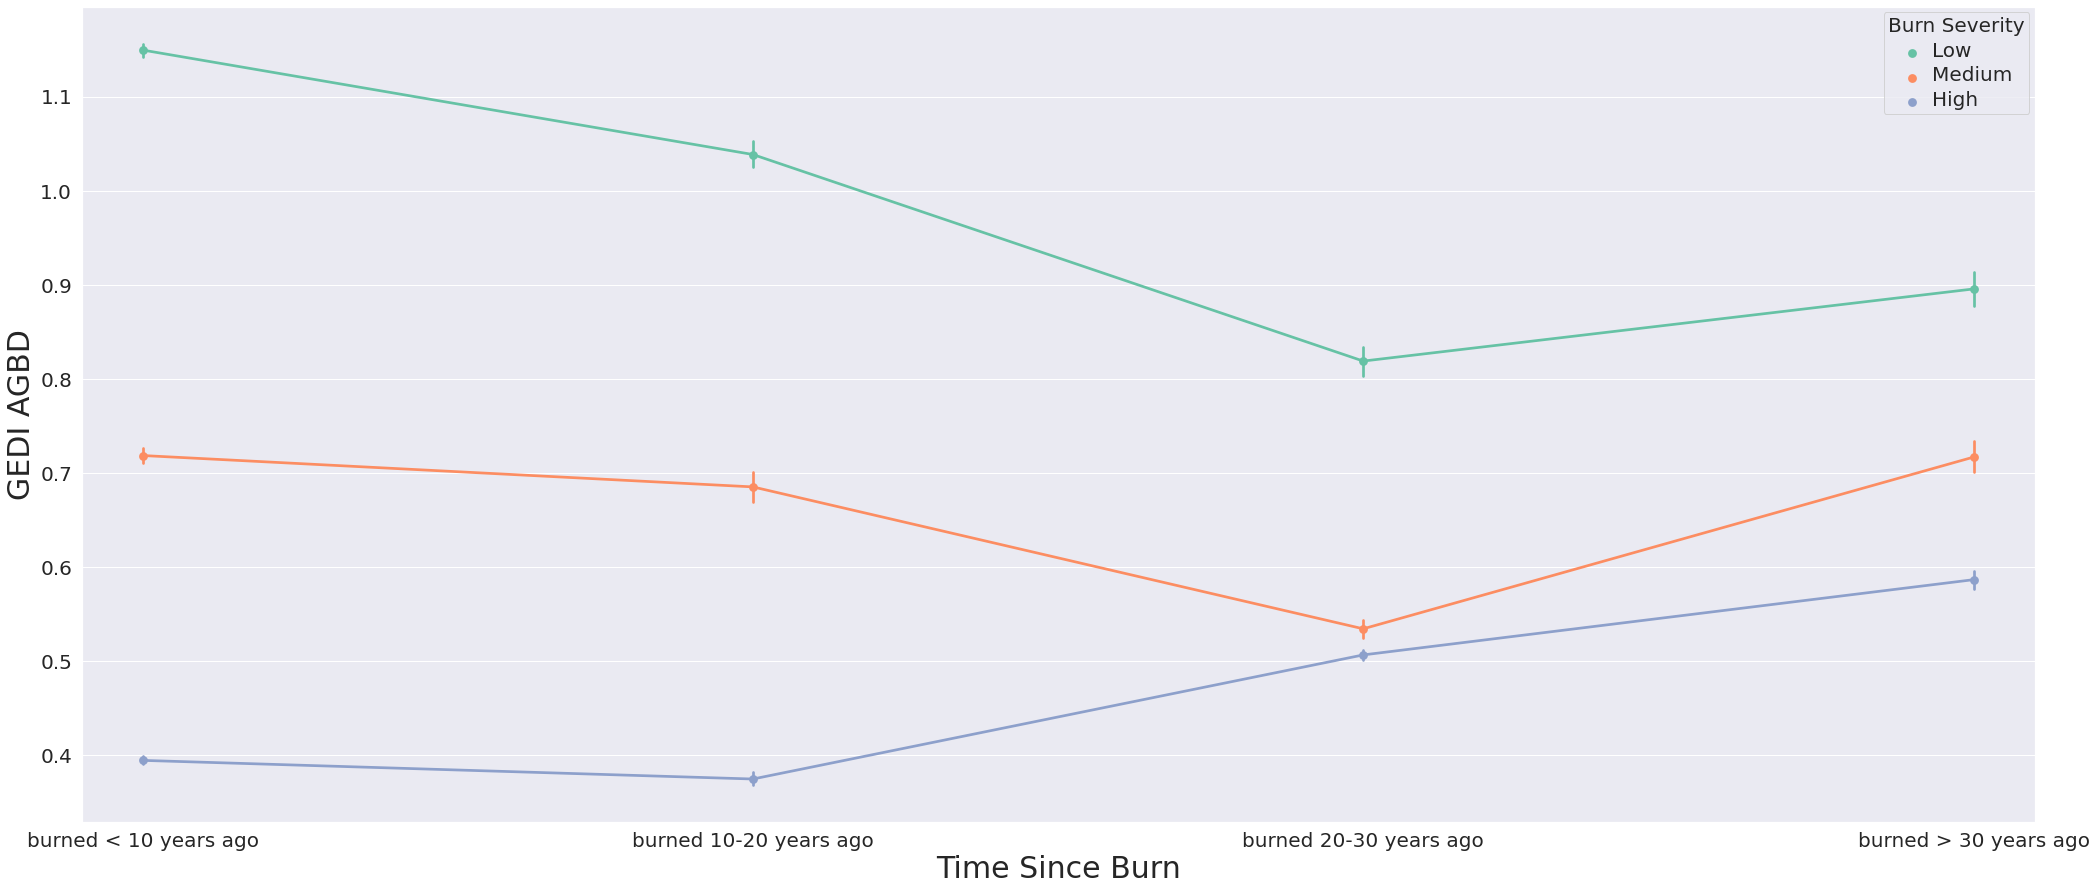

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.pointplot(gedi_burned_trees, x='time_since_burn_cat', y='rel_agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

108723


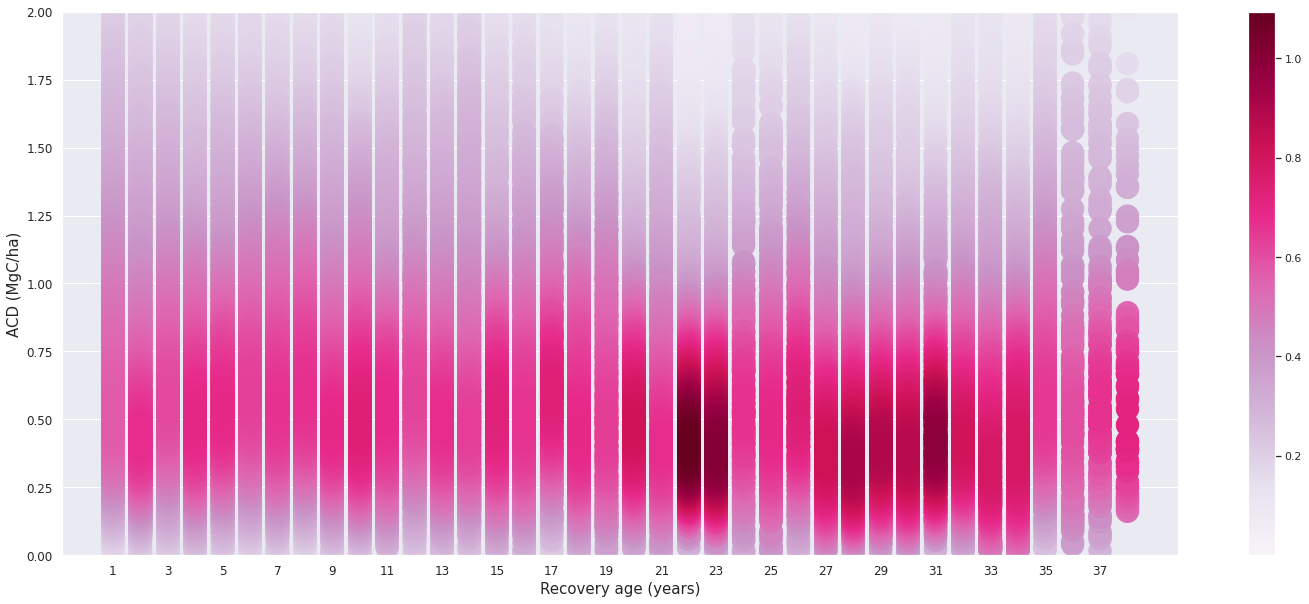

In [26]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

57017


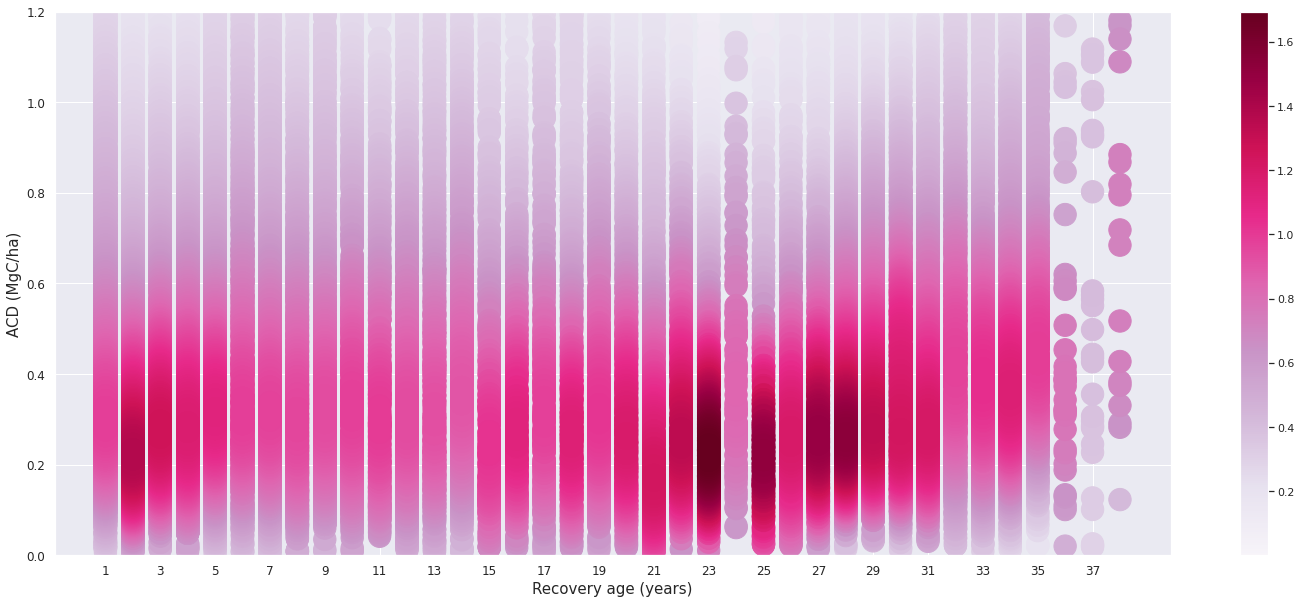

In [28]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1.2))

94900


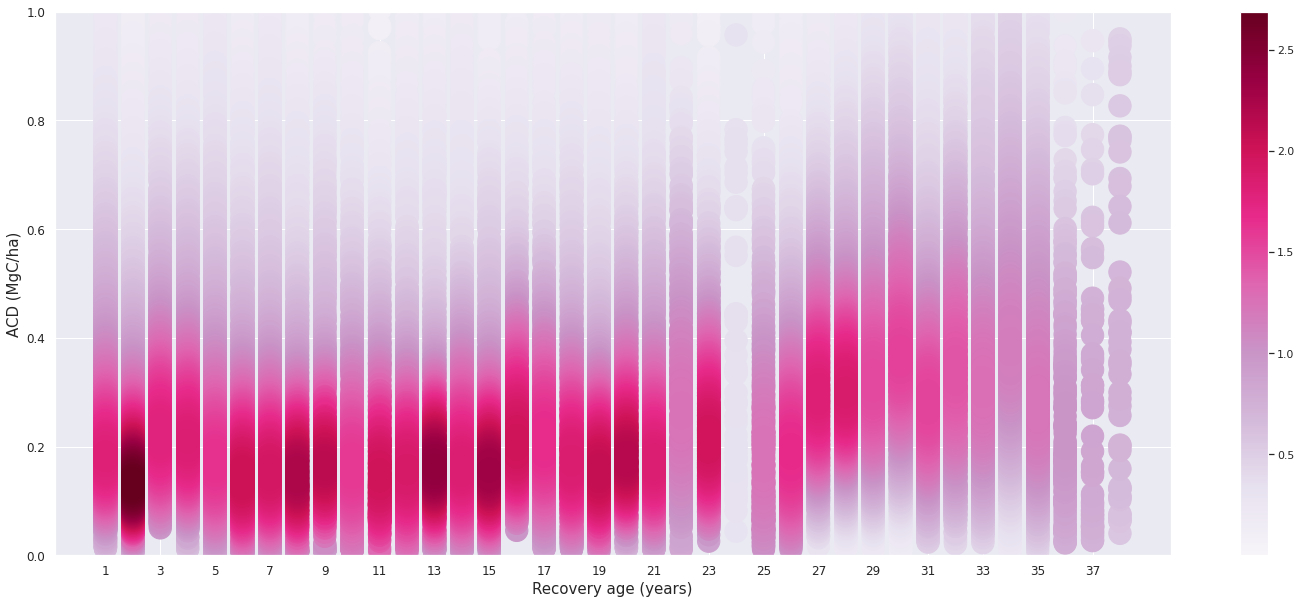

In [16]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 1))

### Visualize nearest neighbor on a map

In [132]:
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

In [ ]:
nn_indeces, nn_distances, nn_avg_agbd 

In [140]:
nn_indeces[:10].flatten()

array([ 272026, 2105486,  272025, ...,  225591,  216215,  216654])

In [145]:
gedi_unburned_trees.reset_index(drop=True).loc[nn_indeces[0]]

shot_number                    absolute_time  lon_lowestmode  \
272026   169791100200077419 2021-12-11 17:35:08.784090+00:00     -121.065098   
2105486  185961100200077165 2022-03-26 00:19:55.183946+00:00     -121.064812   
272025   169791100200077418 2021-12-11 17:35:08.775824+00:00     -121.065606   
272024   169791100200077417 2021-12-11 17:35:08.767558+00:00     -121.066117   
2105485  185961100200077162 2022-03-26 00:19:55.159154+00:00     -121.066341   
...                     ...                              ...             ...   
272000   174560200300287347 2022-01-11 12:14:39.752064+00:00     -121.094374   
272064   169790600200452903 2021-12-11 17:35:08.160107+00:00     -121.094223   
2092194  169790500200077624 2021-12-11 17:35:08.279935+00:00     -121.094436   
98        48550800200082735 2019-10-21 14:57:33.444389+00:00     -121.089381   
2161465   94310800200083044 2020-08-11 18:10:52.332335+00:00     -121.089455   

         lat_lowestmode       agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
272026        38.520528  37.052006      10.333430      80.272758   2.985093   
2105486       38.520339  34.433990       8.976334      76.388359   2.984105   
272025        38.520202  35.918766       9.740457      78.596809   2.984648   
272024        38.519876  83.569946      39.109993     144.709381   3.017167   
2105485       38.519347  78.734879      12.913584     200.307037  10.294710   
...                 ...        ...            ...            ...        ...   
272000        38.525065  29.999155   -9999.000000     120.148521  11.105733   
272064        38.517198  38.202065      10.943408      81.965515   2.985569   
2092194       38.524492  67.203918       7.370712     187.161377  11.100927   
98            38.491150  78.826050      35.910164     138.398682   3.013059   
2161465       38.491356  63.694134      26.017826     117.960312   3.000957   

         l2_quality_flag  l4_quality_flag  ...  burn_counts_mean  \
272026                 1                1  ...               0.0   
2105486                1                1  ...               0.0   
272025                 1                1  ...               0.0   
272024                 1                1  ...               0.0   
2105485                1                1  ...               0.0   
...                  ...              ...  ...               ...   
272000                 1                1  ...               0.0   
272064                 1                1  ...               0.0   
2092194                1                1  ...               0.0   
98                     1                1  ...               0.0   
2161465                1                1  ...               0.0   

        burn_counts_std  burn_counts_median  land_cover_2x2 land_cover_mean  \
272026              0.0                 0.0       [1 1 1 1]             1.0   
2105486             0.0                 0.0       [1 1 1 1]             1.0   
272025              0.0                 0.0       [1 1 1 1]             1.0   
272024              0.0                 0.0       [1 1 1 1]             1.0   
2105485             0.0                 0.0       [1 1 1 1]             1.0   
...                 ...                 ...             ...             ...   
272000              0.0                 0.0       [1 1 1 1]             1.0   
272064              0.0                 0.0       [1 1 1 1]             1.0   
2092194             0.0                 0.0       [1 1 1 1]             1.0   
98                  0.0                 0.0       [1 1 1 1]             1.0   
2161465             0.0                 0.0       [1 1 1 1]             1.0   

        land_cover_std  land_cover_median  gedi_year  gedi_month  \
272026             0.0                1.0       2021          12   
2105486            0.0                1.0       2022           3   
272025             0.0                1.0       2021          12   
272024             0.0                1.0       2021          12   


In [152]:
top_10_burned = gedi_burned_trees.head(1)
top_10_unburned_nns = gedi_unburned_trees.reset_index(drop=True).loc[nn_indeces[:1].flatten()]

In [151]:
top_10_burned

shot_number                    absolute_time  lon_lowestmode  \
30377  141320600300524403 2021-06-11 01:03:13.232091+00:00     -121.065232   
30378  141320600300524405 2021-06-11 01:03:13.248619+00:00     -121.064224   
30379  141320600300524406 2021-06-11 01:03:13.256883+00:00     -121.063721   
30381  141320600300524408 2021-06-11 01:03:13.273411+00:00     -121.062714   
30479  169790800200082537 2021-12-11 17:35:08.887395+00:00     -121.066418   
30503   94310500200077591 2020-08-11 18:10:52.592705+00:00     -121.064539   
30532   48550500200077194 2019-10-21 14:57:33.704756+00:00     -121.064522   
30533   48550500200077195 2019-10-21 14:57:33.713022+00:00     -121.064018   
47711  207320800200083332 2022-08-10 17:42:33.996242+00:00     -120.660378   
47712  207320800200083333 2022-08-10 17:42:34.004508+00:00     -120.659887   

       lat_lowestmode       agbd  agbd_pi_lower  agbd_pi_upper   agbd_se  \
30377       38.523326  29.816301       6.703417      69.418312  2.982733   
30378       38.522668  28.796034       6.224873      67.855049  2.982503   
30379       38.522340  48.694904      16.833782      97.090446  2.990923   
30381       38.521683  21.426817       3.090621      56.247093  2.981820   
30479       38.526989  16.838388       1.518356      48.646515  2.982546   
30503       38.523062  15.311873       1.084821      46.029858  2.983059   
30532       38.522867  16.424440       1.395714      47.941940  2.982670   
30533       38.523194  51.417576      18.443096     100.935516  2.992563   
47711       37.898764  46.550503      15.587555      94.041069  2.989698   
47712       37.899093  31.203169       7.368362      71.529083  2.983091   

       l2_quality_flag  l4_quality_flag  ...  burn_counts_std  \
30377                1                1  ...              0.0   
30378                1                1  ...              0.0   
30379                1                1  ...              0.0   
30381                1                1  ...              0.0   
30479                1                1  ...              0.0   
30503                1                1  ...              0.0   
30532                1                1  ...              0.0   
30533                1                1  ...              0.0   
47711                1                1  ...              0.0   
47712                1                1  ...              0.0   

      burn_counts_median  land_cover_2x2  land_cover_mean land_cover_std  \
30377                1.0       [1 1 1 1]              1.0            0.0   
30378                1.0       [1 1 1 1]              1.0            0.0   
30379                1.0       [1 1 1 1]              1.0            0.0   
30381                1.0       [1 1 1 1]              1.0            0.0   
30479                1.0       [1 1 1 1]              1.0            0.0   
30503                1.0       [1 1 1 1]              1.0            0.0   
30532                1.0       [1 1 1 1]              1.0            0.0   
30533                1.0       [1 1 1 1]              1.0            0.0   
47711                1.0       [1 1 1 1]              1.0            0.0   
47712                1.0       [1 1 1 1]              1.0            0.0   

      land_cover_median  gedi_year  gedi_month  time_since_burn  rel_agbd  
30377               1.0       2021           6              4.0  0.486971  
30378               1.0       2021           6              4.0  0.462693  
30379               1.0       2021           6              4.0  0.781496  
30381               1.0       2021           6              4.0  0.338248  
30479               1.0       2021          12              4.0  0.277308  
30503               1.0       2020           8              3.0  0.245547  
30532               1.0       2019          10              2.0  0.263388  
30533               1.0       2019          10              2.0  0.825363  
47711               1.0       2022           8             18.0  0.437900  
47712

(38.4, 38.6)

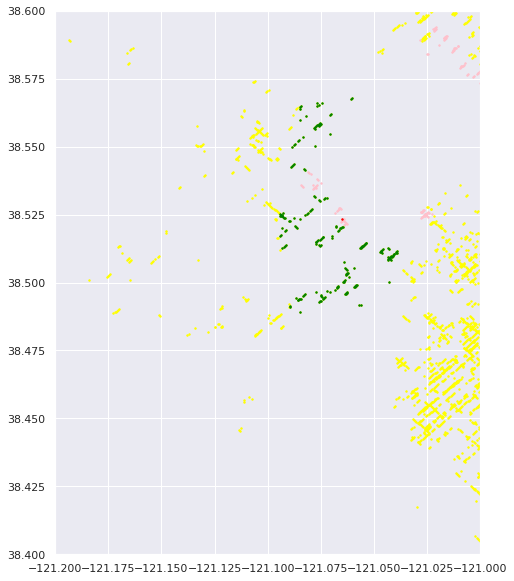

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
#sierras.boundary.plot(ax=ax)
gedi_burned_trees.plot(ax=ax, markersize=2, color='pink')
gedi_unburned_trees.plot(ax=ax, markersize=2, color='yellow')
top_10_unburned_nns.plot(ax=ax, markersize=2, color='green')
top_10_burned.plot(ax=ax, markersize=2, color='red')
ax.set_xlim((-121.2, -121))
ax.set_ylim((38.4, 38.6))


### Polynomial regression

In [128]:
polynomial_features= PolynomialFeatures(degree=3)

gedi_burn_4 = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2]
gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2)]
#model = sm.OLS(gedi_burn_4['rel_agbd'], polynomial_features.fit_transform(gedi_burn_4['time_since_burn'])).fit()
#model = sm.OLS(gedi_burn_4['rel_agbd'], sm.add_constant(gedi_burn_4['time_since_burn'])).fit()

#print(model.summary())
#polynomial_features.fit_transform(gedi_burn_4['time_since_burn'])
x = np.reshape(gedi_burn_4['time_since_burn'].to_numpy(), (gedi_burn_4['time_since_burn'].to_numpy().shape[0], 1))
y = np.reshape(gedi_burn_4['rel_agbd'].to_numpy(), (gedi_burn_4['rel_agbd'].to_numpy().shape[0], 1))
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
#print(model.summary())

(0.0, 2.0)

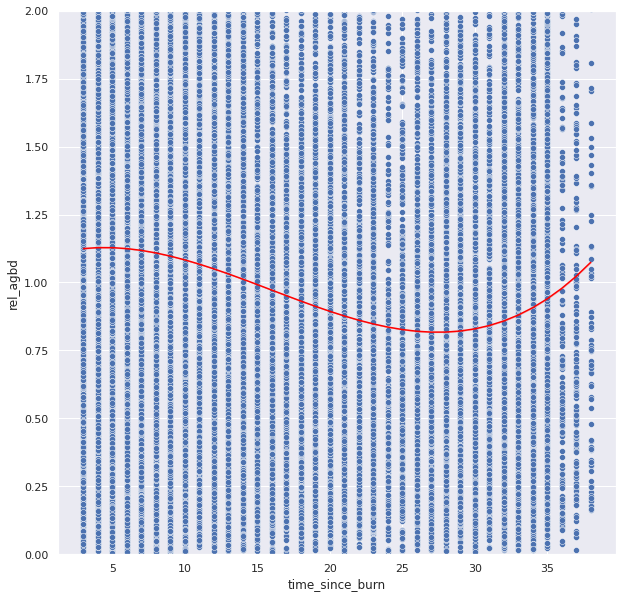

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(gedi_burn_4, x='time_since_burn', y='rel_agbd', ax=ax)
sns.lineplot(x=gedi_burn_4.time_since_burn, y=ypred, color='red', ax=ax)
#sns.lineplot(x=gedi_burn_4.time_since_burn, y=upper, color='green', ax=ax)
#sns.lineplot(x=gedi_burn_4.time_since_burn, y=lower, color='green', ax=ax)
#plt.scatter(x, y)
#plt.pointplot(x, ypred, color='red')
plt.ylim((0, 2))

### Quantile regression

In [94]:
import statsmodels.formula.api as smf

In [121]:
gedi_burn_4 = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]
#gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2) & (gedi_burn_4.time_since_burn < 36)]
gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2)]

In [122]:
mod = smf.quantreg("rel_agbd ~ time_since_burn", gedi_burn_4)

In [123]:
quantiles = np.arange(0.05, 0.96, 0.01)
def fit_model(q):
    res = mod.fit(q=q)
    return [
        q, 
        res.params["Intercept"],
        *res.conf_int().loc["Intercept"],
        res.params["time_since_burn"],
        *res.conf_int().loc["time_since_burn"],
        res.prsquared,
    ]


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "la", "ua", "b", "lb", "ub", "prs"])
print(models)

print(mod.fit(q=0.5).summary())
median = fit_model(0.5)
median = dict(
    q=median[0],
    a=median[1],
    la=median[2],
    ua=median[3],
    b=median[4],
    lb=median[5],
    ub=median[6],
    prs = median[7]
)

bestmod = models[models.prs == models.prs.max()].iloc[0]
print(bestmod)

       q         a        la        ua         b        lb        ub       prs
0   0.05  0.027191  0.023963  0.030418  0.002684  0.002546  0.002822  0.018736
1   0.06  0.033043  0.029948  0.036138  0.002790  0.002658  0.002923  0.020191
2   0.07  0.036040  0.032978  0.039102  0.002980  0.002850  0.003111  0.021194
3   0.08  0.038575  0.035538  0.041611  0.003179  0.003049  0.003308  0.021888
4   0.09  0.040511  0.037492  0.043529  0.003408  0.003280  0.003537  0.022638
..   ...       ...       ...       ...       ...       ...       ...       ...
86  0.91  0.797547  0.771741  0.823352  0.009285  0.008156  0.010414  0.010851
87  0.92  0.844885  0.813295  0.876475  0.009487  0.008105  0.010869  0.010401
88  0.93  0.900542  0.869599  0.931484  0.009825  0.008471  0.011178  0.010308
89  0.94  0.959211  0.922718  0.995703  0.010598  0.009002  0.012194  0.010066
90  0.95  1.050267  1.014340  1.086194  0.010644  0.009073  0.012216  0.010289

[91 rows x 8 columns]
                         Quan

(0.0, 2.0)

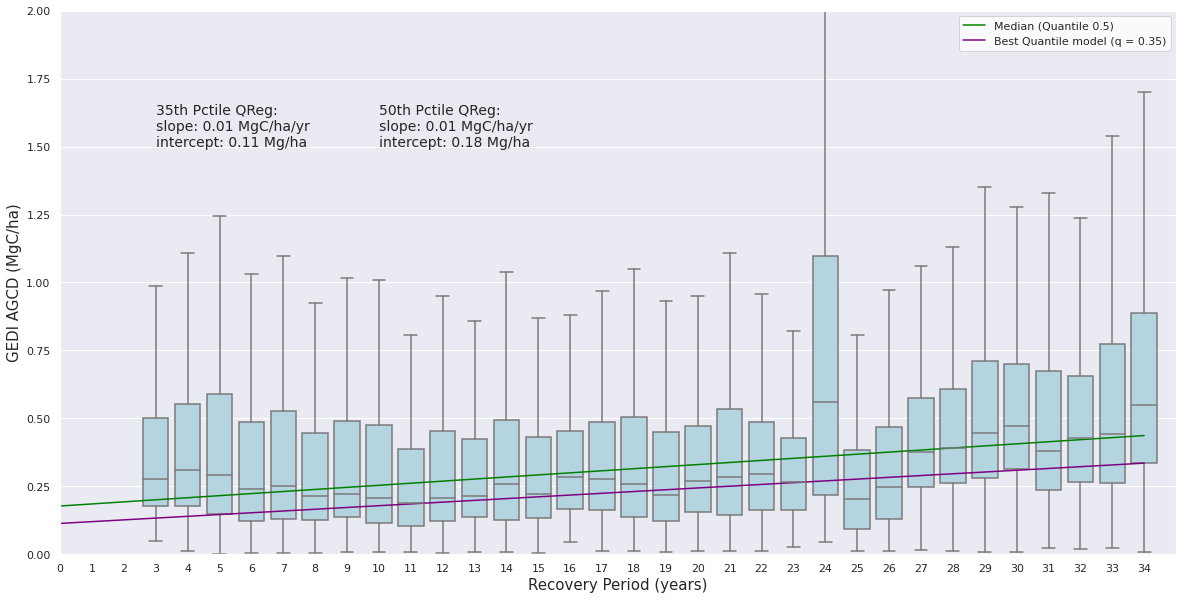

In [124]:
plt.figure(1, (20,10))
ax = sns.boxplot(x="time_since_burn", y="rel_agbd", data=gedi_burn_4, color='lightblue', showfliers=False, order=np.arange(35))
ax.set_ylabel("GEDI AGCD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,35])
xs = np.arange(0, 35)

# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
# for i in range(0,models.shape[0], 10):
#     ys = get_ys(models.a[i], models.b[i])
#     ax.plot(xs, ys, linestyle="dotted", color=cmap(i), label='Quantile {0:.2f}'.format(models.q[i]))


med_ys = get_ys(median['a'], median['b'])
ax.plot(xs, med_ys, color='green', label='Median (Quantile 0.5)')

ys_best = get_ys(bestmod['a'], bestmod['b'])
ax.plot(xs, ys_best, color='purple', label='Best Quantile model (q = {0:.2f})'.format(bestmod['q']))

#ax.plot(xs, lin_agcd.intercept + lin_agcd.slope * xs, 'r', label='OLS')
#text_label = (
#    "OLS Regression:\n"
#    "R-value: {0:.2f}\n"
#    "slope: {1:.2f} MgC/ha/yr\n"
#    "intercept: {2:.2f} Mg/ha").format(
#        lin_agcd.rvalue, lin_agcd.slope, lin_agcd.intercept)
#ax.text(x=6, y=205, s=text_label, fontsize=14)

text_label_2 = (
    "50th Pctile QReg:\n"
    "slope: {0:.2f} MgC/ha/yr\n"
    "intercept: {1:.2f} Mg/ha").format(
        median['b'], median['a'])
ax.text(x=10, y=1.5, s=text_label_2, fontsize=14)

text_label_3 = (
    "{0:.0f}th Pctile QReg:\n"
    "slope: {1:.2f} MgC/ha/yr\n"
    "intercept: {2:.2f} Mg/ha").format(
        bestmod['q'] * 100, bestmod['b'], bestmod['a'])
ax.text(x=3, y=1.5, s=text_label_3, fontsize=14)
ax.legend(facecolor='white')
ax.set_ylim([0, 2])

### Linear regression

In [79]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [29]:
gedi_burn_4 = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4]
#gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2) & (gedi_burn_4.time_since_burn < 36)]
gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2)]
model = sm.OLS(gedi_burn_4['rel_agbd'], sm.add_constant(gedi_burn_4['time_since_burn'])).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               rel_agbd   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1653.
Date:                Sun, 14 May 2023   Prob (F-statistic):               0.00
Time:                        11:58:57   Log-Likelihood:                -36887.
No. Observations:               60697   AIC:                         7.378e+04
Df Residuals:                   60695   BIC:                         7.380e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3134      0.004     

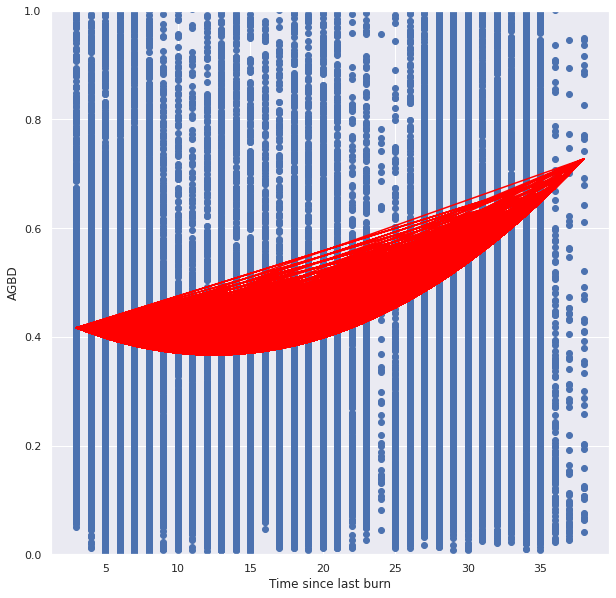

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc = plt.scatter(gedi_burn_4['time_since_burn'], gedi_burn_4['rel_agbd'])#, c = pd.Categorical(master_climate['polygon_id']).codes)
plt.plot(gedi_burn_4['time_since_burn'], model.predict(xp), color='red')
plt.xlabel('Time since last burn')
plt.ylabel('AGBD')
plt.ylim((0, 1))
#categories = [i for i in range(1,9)]
#handles, labels = sc.legend_elements()
#plt.legend(handles, categories, title='Polygon')
plt.show()

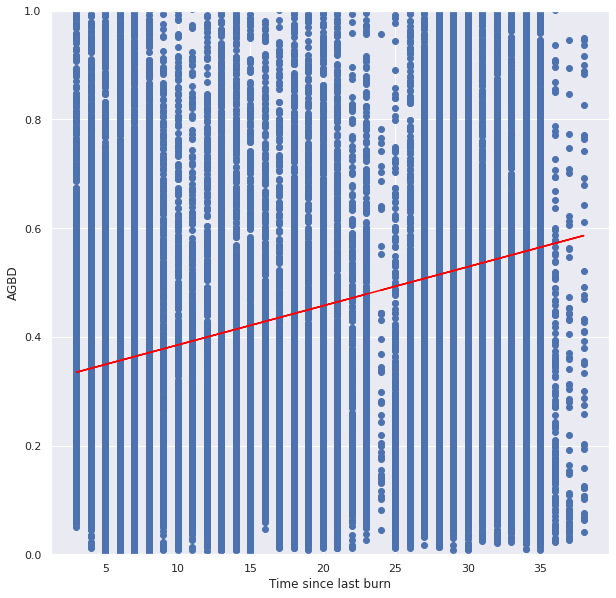

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc = plt.scatter(gedi_burn_4['time_since_burn'], gedi_burn_4['rel_agbd'])#, c = pd.Categorical(master_climate['polygon_id']).codes)
plt.plot(gedi_burn_4['time_since_burn'], model.predict(), color='red')
plt.xlabel('Time since last burn')
plt.ylabel('AGBD')
plt.ylim((0, 1))
#categories = [i for i in range(1,9)]
#handles, labels = sc.legend_elements()
#plt.legend(handles, categories, title='Polygon')
plt.show()

In [34]:
gedi_burn_4 = gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3]
#gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2) & (gedi_burn_4.time_since_burn < 36)]
gedi_burn_4 = gedi_burn_4[(gedi_burn_4.time_since_burn > 2)]
model = sm.OLS(gedi_burn_4['rel_agbd'], sm.add_constant(gedi_burn_4['time_since_burn'])).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               rel_agbd   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     81.35
Date:                Sun, 14 May 2023   Prob (F-statistic):           1.97e-19
Time:                        12:00:46   Log-Likelihood:                -38593.
No. Observations:               38254   AIC:                         7.719e+04
Df Residuals:                   38252   BIC:                         7.721e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7095      0.007    1

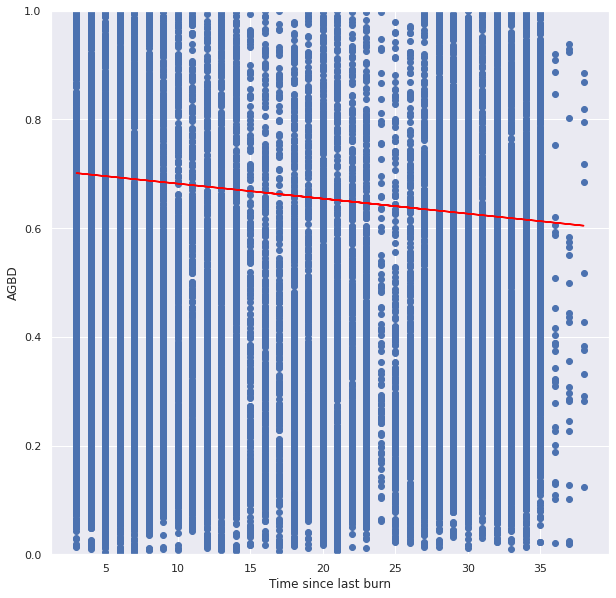

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc = plt.scatter(gedi_burn_4['time_since_burn'], gedi_burn_4['rel_agbd'])#, c = pd.Categorical(master_climate['polygon_id']).codes)
plt.plot(gedi_burn_4['time_since_burn'], model.predict(), color='red')
plt.xlabel('Time since last burn')
plt.ylabel('AGBD')
plt.ylim((0, 1))
#categories = [i for i in range(1,9)]
#handles, labels = sc.legend_elements()
#plt.legend(handles, categories, title='Polygon')
plt.show()

### Plot the data geographically

In [31]:
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

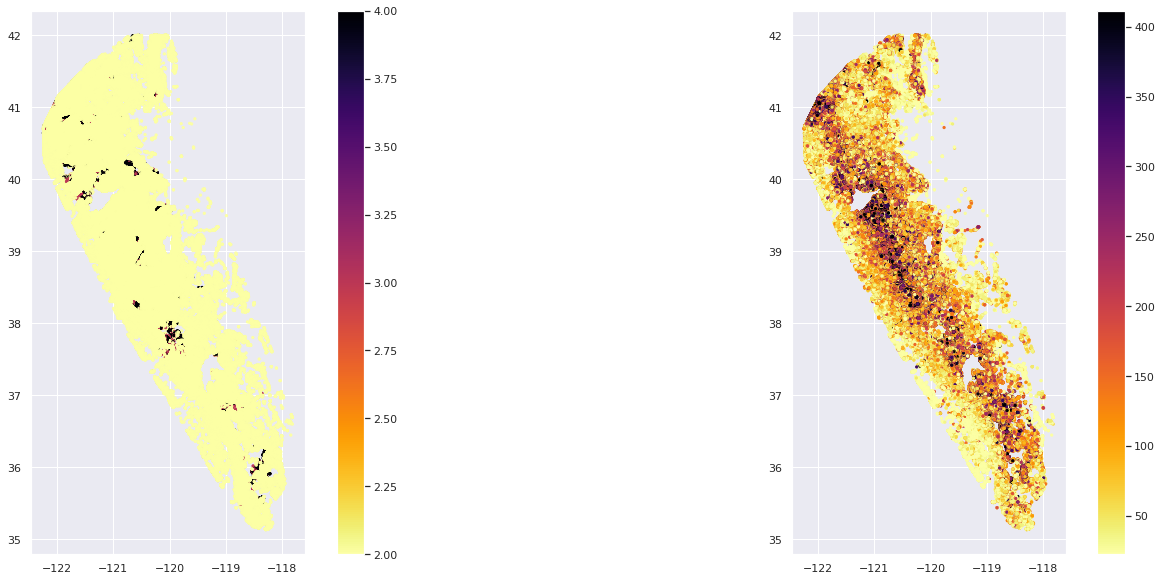

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))
geo_plot(gedi_trees, ax[0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees, ax[1], 'agbd')

<AxesSubplot: >

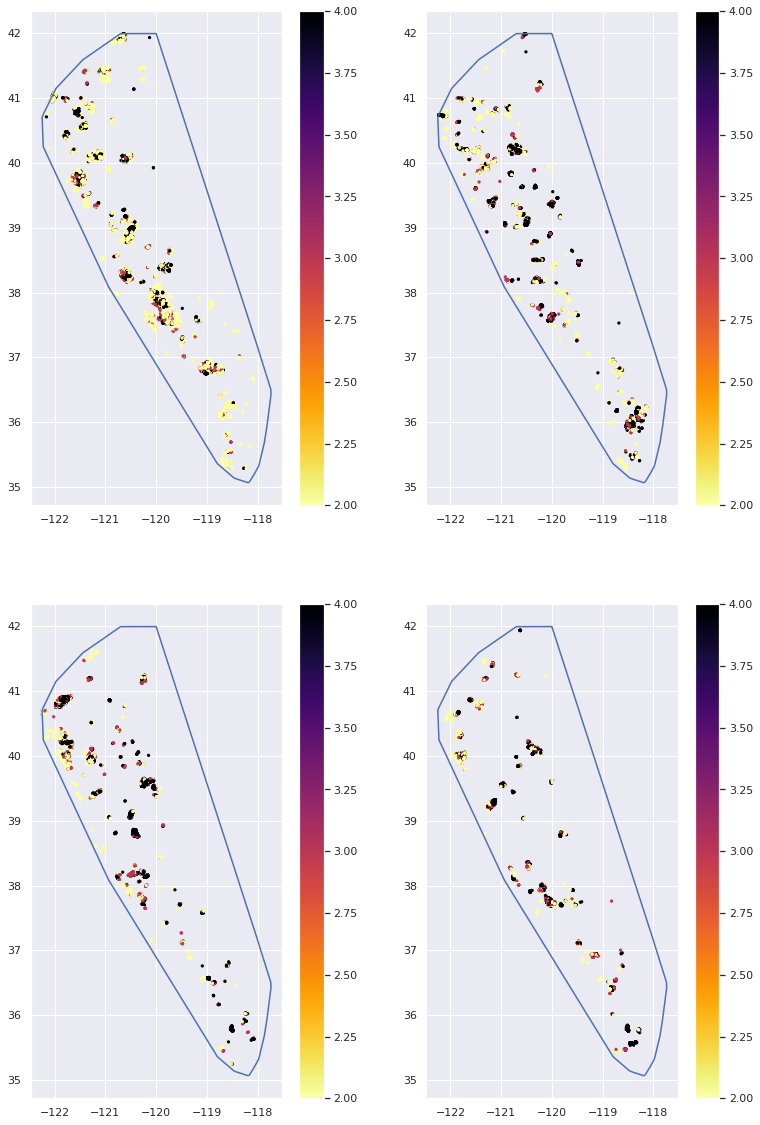

In [204]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'], ax[0][0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'], ax[0][1], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'], ax[1][0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'], ax[1][1], 'burn_severity_median', vmin=2, vmax=4)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

<AxesSubplot: >

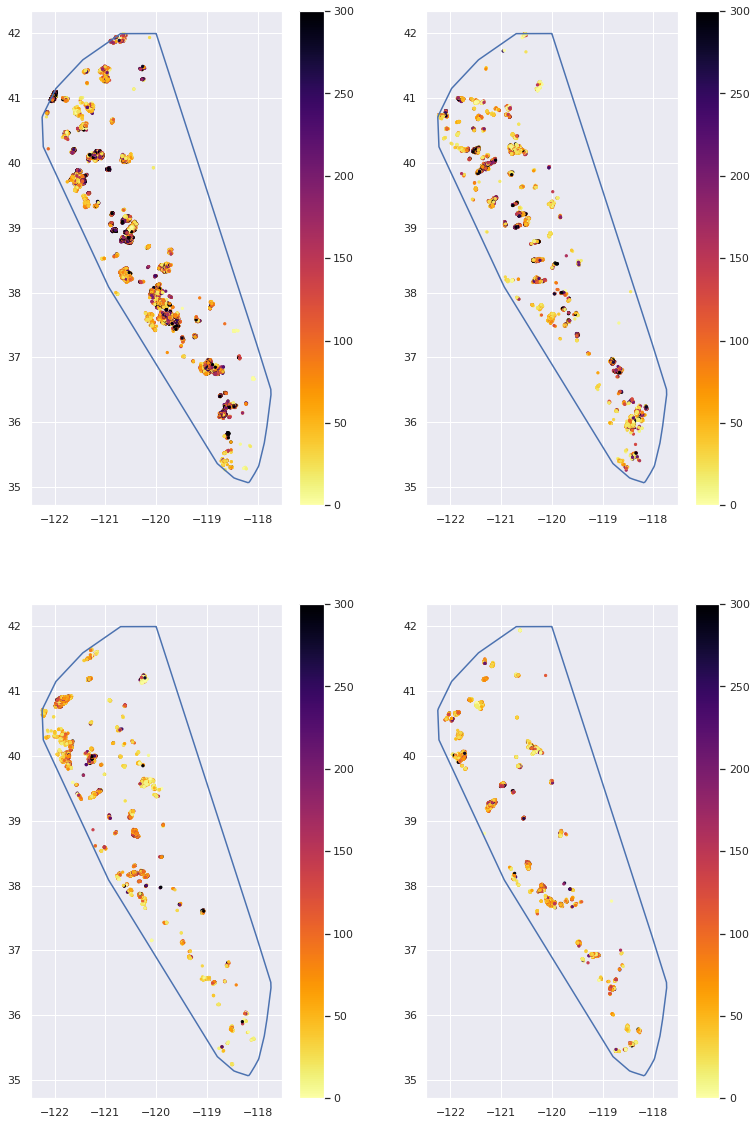

In [222]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'], ax[0][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'], ax[0][1], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'], ax[1][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'], ax[1][1], 'agbd', vmin=0, vmax=300)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

<AxesSubplot: >

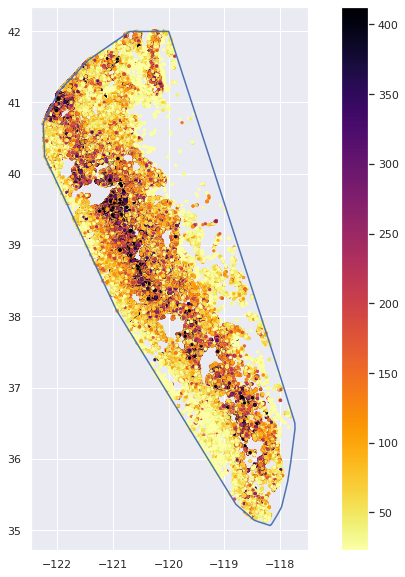

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'unburned'], ax, 'agbd')
sierras.boundary.plot(ax=ax)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

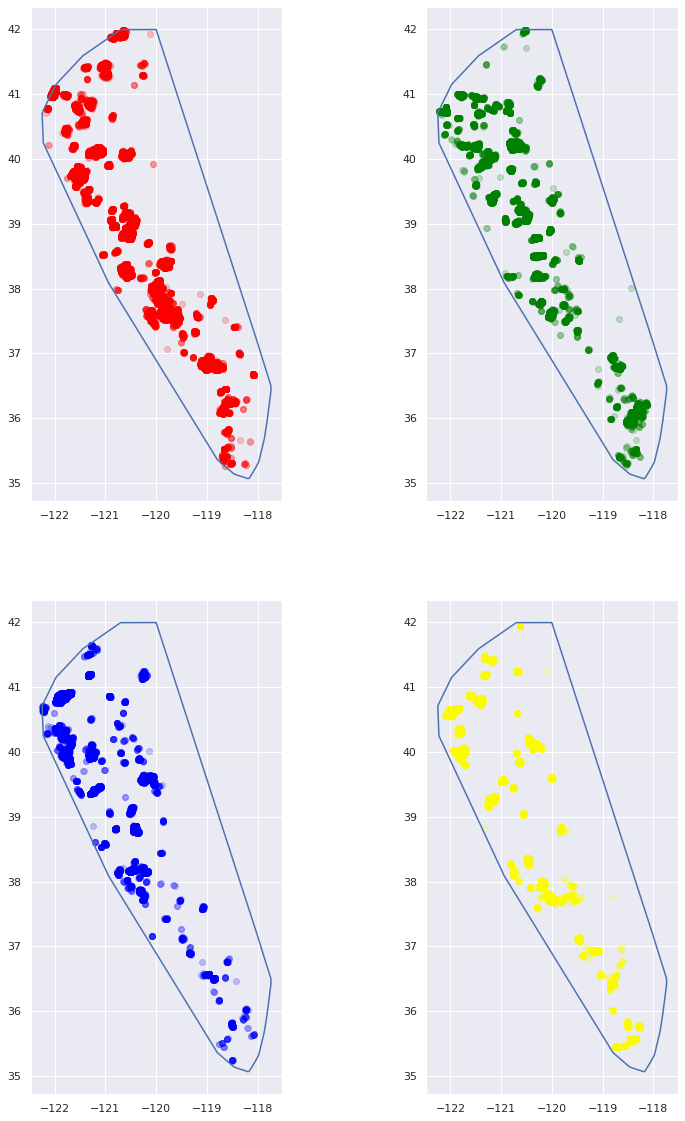

In [210]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'].plot(column='agbd', ax=ax[0][0], legend=True, color='red', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'].plot(column='agbd', ax=ax[0][1], legend=True, color='green', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'].plot(column='agbd', ax=ax[1][0], legend=True, color='blue', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'].plot(column='agbd', ax=ax[1][1], legend=True, color='yellow', alpha=0.2)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


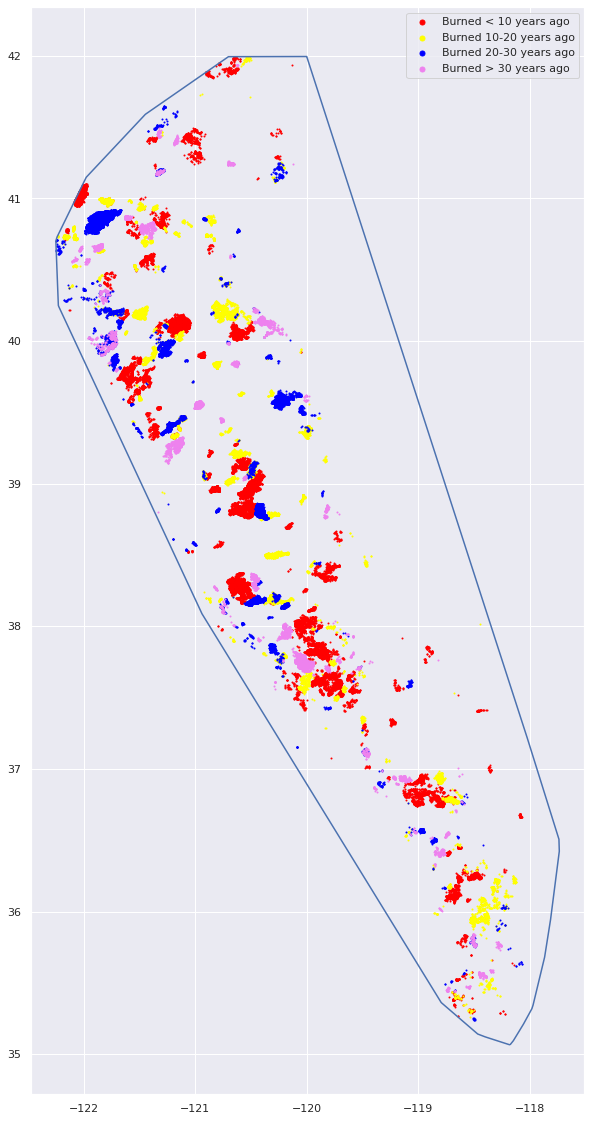

In [219]:
fig, ax = plt.subplots(1,1, figsize=(13, 20))
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'].plot(column='agbd', ax=ax, legend=True, color='red', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'].plot(column='agbd', ax=ax, legend=True, color='yellow', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'].plot(column='agbd', ax=ax, legend=True, color='blue', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'].plot(column='agbd', ax=ax, legend=True, color='violet', markersize=1)

sierras.boundary.plot(ax=ax)
plt.legend(['Burned < 10 years ago', 'Burned 10-20 years ago', 'Burned 20-30 years ago', 'Burned > 30 years ago'], markerscale = 5)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_trees[gedi_burned_trees.burn_severity_sample == 2], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 1], x='time_since_burn', y='agbd', color='red')

### Look at unburned region

In [73]:
print(f'GEDI unburned shots: {gedi_unburned.shape[0]}')
print(f'GEDI unburned tree shots: {gedi_unburned_trees.shape[0]}')

GEDI unburned shots: 7829875


In [78]:
print('AGBD stats for unburned')
print(gedi_unburned_trees.agbd.describe())

print('AGBD stats for burned')
print(gedi_burned_trees.agbd.describe())

AGBD stats for unburned
count    2.856458e+06
mean     1.531952e+02
std      1.317868e+02
min      4.797173e-01
25%      5.792078e+01
50%      1.157059e+02
75%      2.078579e+02
max      4.822505e+03
Name: agbd, dtype: float64
AGBD stats for burned
count    126224.000000
mean        110.389136
std         122.778903
min           0.834731
25%          32.127316
50%          69.451138
75%         136.369278
max        2114.207764
Name: agbd, dtype: float64


In [79]:
print('AGBD stats for burned, severity == 2')
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==2].agbd.describe())

print('AGBD stats for burned, severity == 3')
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==3].agbd.describe())

print('AGBD stats for burned, severity == 4')
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4].agbd.describe())

AGBD stats for burned, severity == 2
count    44429.000000
mean       185.359152
std        159.512139
min          0.870713
25%         66.874855
50%        140.779327
75%        256.842957
max       1914.888306
Name: agbd, dtype: float64
AGBD stats for burned, severity == 3
count    17193.000000
mean        87.445992
std         93.397168
min          1.009095
25%         30.505957
50%         58.366970
75%        110.912811
max       2086.356445
Name: agbd, dtype: float64
AGBD stats for burned, severity == 4
count    64602.000000
mean        64.935723
std         59.686386
min          0.834731
25%         24.993123
50%         48.109180
75%         87.826307
max       2114.207764
Name: agbd, dtype: float64


(0.0, 1500.0)

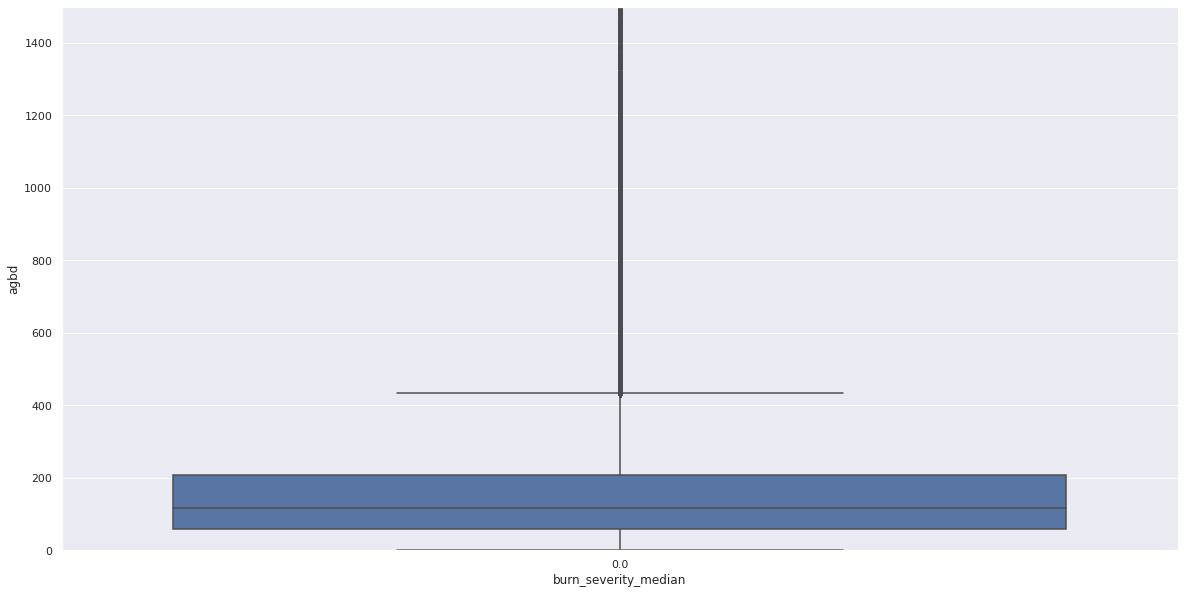

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(gedi_unburned_trees, x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1500))